# Market Price & Planning Assistant for Kenyan Consumers and Farmers

###     Problem Statement

In Kenya, market prices of key food commodities fluctuate unpredictably, often due to seasonal 
changes, weather patterns, middlemen practices, and transport costs. Farmers lack up-to-date and 
reliable information on what prices markets are offering, leaving them vulnerable to exploitation. 
Households and traders are also unable to plan effectively, leading to waste or overspending. 

**Objective 1: Provide Real-Time Market Price Information.**

- Develop a centralized data-driven system that collects, updates, and provides households, 
farmers, and traders with accurate, real-time market price information for key 
commodities.

**Objective 2: Predict Future Price Trends.**

- Implement machine learning models to forecast short- and medium-term price trends, 
enabling users to make informed production, trading, and budgeting decisions. 

**Objective 3: Deliver Insights Through Inclusive and Accessible Channels.**

- Deploy the platform across USSD, web, and web app channels to ensure inclusive access 
and deliver personalized alerts and insights, even in areas with low

### Data Cleaning

### 1. Handling Missing Values.

In [1]:
#import libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.errors.SettingWithCopyWarning)
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, RidgeCV
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from xgboost import XGBRegressor
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping


df = pd.read_csv('merged_commodities.csv')
#display first rows
df.head()

,Commodity,Classification,Market,WholesaleUnitPrice,RetailUnitPrice,Supplyvolume,County,Date
0,Avocado,Fuerte,Kerugoya,50.0,90.0,NaN,Kirinyaga,2025-07-22
1,Avocado,Hass,Voi Retail,NaN,35.0,NaN,Taita-Taveta,2025-07-22
2,Avocado,Fuerte,Chuka,10.0,30.0,NaN,Tharaka-Nithi,2025-07-22
3,Avocado,Local,Voi Wholesale,30.0,NaN,NaN,Taita-Taveta,2025-07-22
4,Avocado,Hass,Kibuye,NaN,150.0,NaN,Kisumu,2025-07-20


In [2]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 63173 entries, 0 to 63172
Data columns (total 8 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Commodity           63173 non-null  object 
 1   Classification      63173 non-null  object 
 2   Market              63173 non-null  object 
 3   WholesaleUnitPrice  48902 non-null  float64
 4   RetailUnitPrice     59144 non-null  float64
 5   Supplyvolume        0 non-null      float64
 6   County              63153 non-null  object 
 7   Date                63173 non-null  object 
dtypes: float64(3), object(5)
memory usage: 3.9+ MB


In [3]:
#drop the supply volume as it has no values(empty)
df.drop('Supplyvolume', axis=1,inplace=True)

- Convert the floats to numeric floats ("WholesaleUnitPrice" and "RetailUnitPrice") .

In [4]:
df["WholesaleUnitPrice"] = pd.to_numeric(df["WholesaleUnitPrice"], errors="coerce")
df["RetailUnitPrice"] = pd.to_numeric(df["RetailUnitPrice"], errors="coerce")

In [5]:
#COMMODITY + MARKET SPECIFIC
def method_commodity_market_median(df):
    """Use commodity-market specific median markup"""
    df_comm_market = df.copy()
    
    # Calculate median markup by commodity-market combination
    complete_cases = df_comm_market.dropna(subset=['WholesaleUnitPrice', 'RetailUnitPrice'])
    if len(complete_cases) > 0:
        comm_market_markups = complete_cases.groupby(['Commodity', 'Market']).apply(
            lambda x: (x['RetailUnitPrice'] / x['WholesaleUnitPrice']).median() if len(x) >= 3 else np.nan
        ).to_dict()
        
        # Fallback to commodity-only if not enough data
        commodity_markups = complete_cases.groupby('Commodity').apply(
            lambda x: (x['RetailUnitPrice'] / x['WholesaleUnitPrice']).median()
        ).to_dict()
        
        global_median = (complete_cases['RetailUnitPrice'] / complete_cases['WholesaleUnitPrice']).median()
    else:
        comm_market_markups = {}
        commodity_markups = {}
        global_median = 1.2
    
    # Fill missing values with hierarchy: commodity-market -> commodity -> global
    for idx, row in df_comm_market.iterrows():
        # Try commodity-market specific first
        markup = comm_market_markups.get((row['Commodity'], row['Market']))
        if pd.isna(markup):
            # Fallback to commodity-specific
            markup = commodity_markups.get(row['Commodity'])
        if pd.isna(markup):
            # Final fallback to global
            markup = global_median
        
        if pd.isna(row['WholesaleUnitPrice']) and pd.notna(row['RetailUnitPrice']):
            df_comm_market.loc[idx, 'WholesaleUnitPrice'] = row['RetailUnitPrice'] / markup
        elif pd.isna(row['RetailUnitPrice']) and pd.notna(row['WholesaleUnitPrice']):
            df_comm_market.loc[idx, 'RetailUnitPrice'] = row['WholesaleUnitPrice'] * markup
    
    return df_comm_market

### Normalize Price Columns
- Create a single “ReferencePrice” column (average of wholesale & retail) for general analysis.

In [6]:
df["ReferencePrice"] = df[["WholesaleUnitPrice", "RetailUnitPrice"]].mean(axis=1)

###  Standardize Classifications

- Ensure consistent naming (Title).

- If there were typos or mixed cases(we're fixing it).

In [7]:
df["Classification"] = df["Classification"].str.title().str.strip()

### Clean Market and County Names

- Remove extra spaces, fix casing:

In [8]:
df["Market"] = df["Market"].str.title().str.strip()
df["County"] = df["County"].str.title().str.strip()

### Convert Dates

- Make sure Date is a proper datetime.

In [9]:
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

In [10]:
#create another column for Months extracting it from the date column
df['month_num'] = df['Date'].dt.month

# Extract month name (January, February, etc.)
df['Month_name'] = df['Date'].dt.month_name()

df.drop('month_num', axis=1, inplace=True)

# Extract Year
df['Year'] = df['Date'].dt.year

# Extract Day of Month (date)
df['Day_Name'] = df['Date'].dt.day_name()

### Finalize Columns

- Drop duplicates, re-order, and keep the cleaned schema

In [11]:
df = df.drop_duplicates()
df = df[["Commodity", "Classification", "Market", "WholesaleUnitPrice",
         "RetailUnitPrice", "ReferencePrice", "County", "Date", "Month_name","Year","Day_Name"]]

In [12]:
#view the final cleaned dataset
df.head()

,Commodity,Classification,Market,WholesaleUnitPrice,RetailUnitPrice,ReferencePrice,County,Date,Month_name,Year,Day_Name
0,Avocado,Fuerte,Kerugoya,50.0,90.0,70.0,Kirinyaga,2025-07-22,July,2025,Tuesday
1,Avocado,Hass,Voi Retail,NaN,35.0,35.0,Taita-Taveta,2025-07-22,July,2025,Tuesday
2,Avocado,Fuerte,Chuka,10.0,30.0,20.0,Tharaka-Nithi,2025-07-22,July,2025,Tuesday
3,Avocado,Local,Voi Wholesale,30.0,NaN,30.0,Taita-Taveta,2025-07-22,July,2025,Tuesday
4,Avocado,Hass,Kibuye,NaN,150.0,150.0,Kisumu,2025-07-20,July,2025,Sunday


In [13]:
df.shape

(61430, 11)

## Exploratory Data Analysis

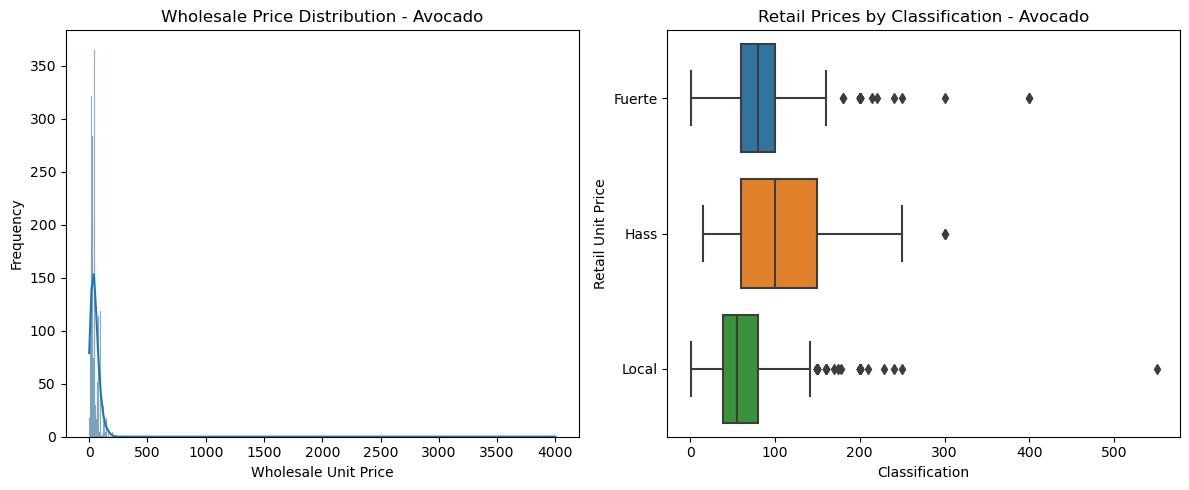

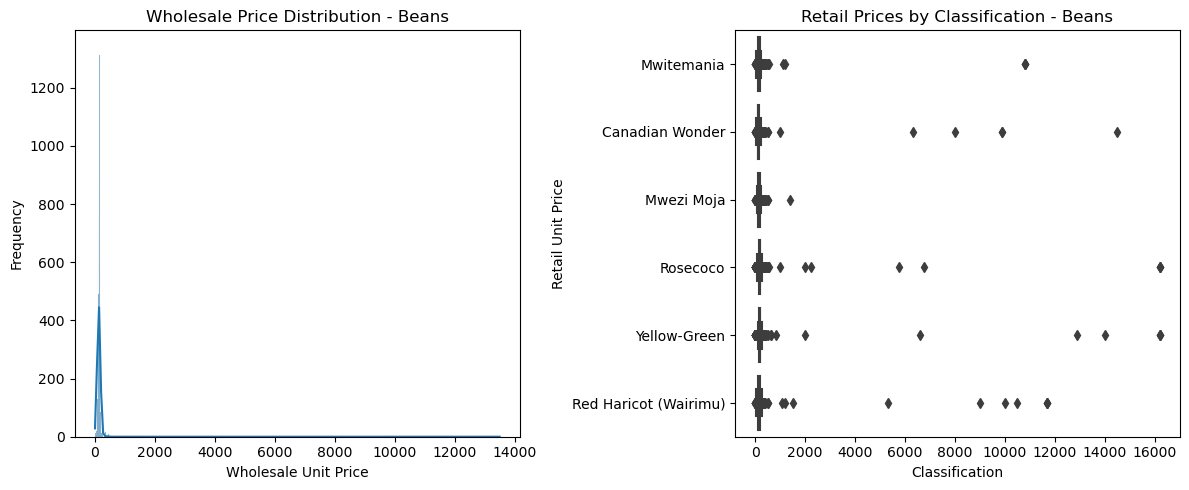

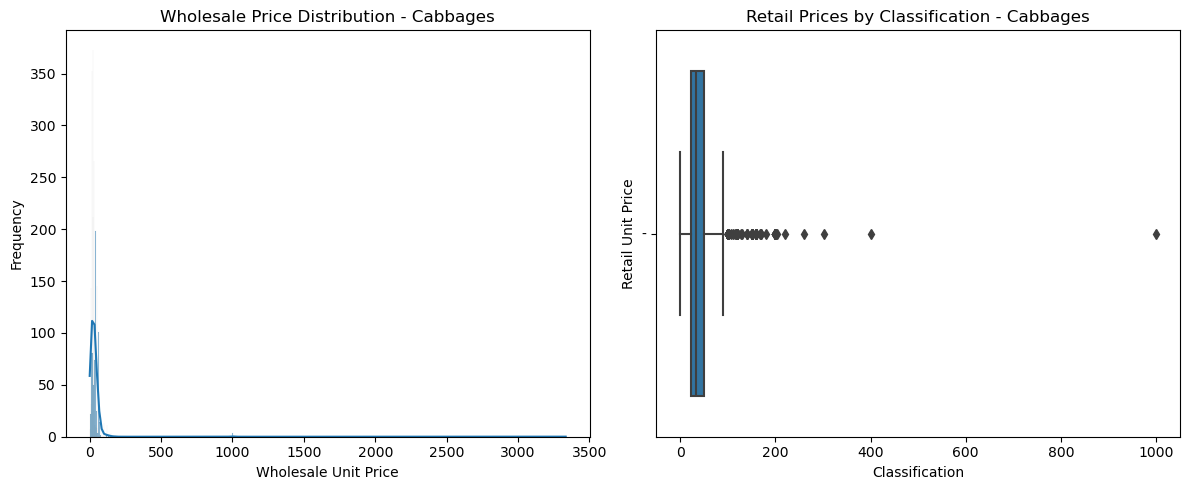

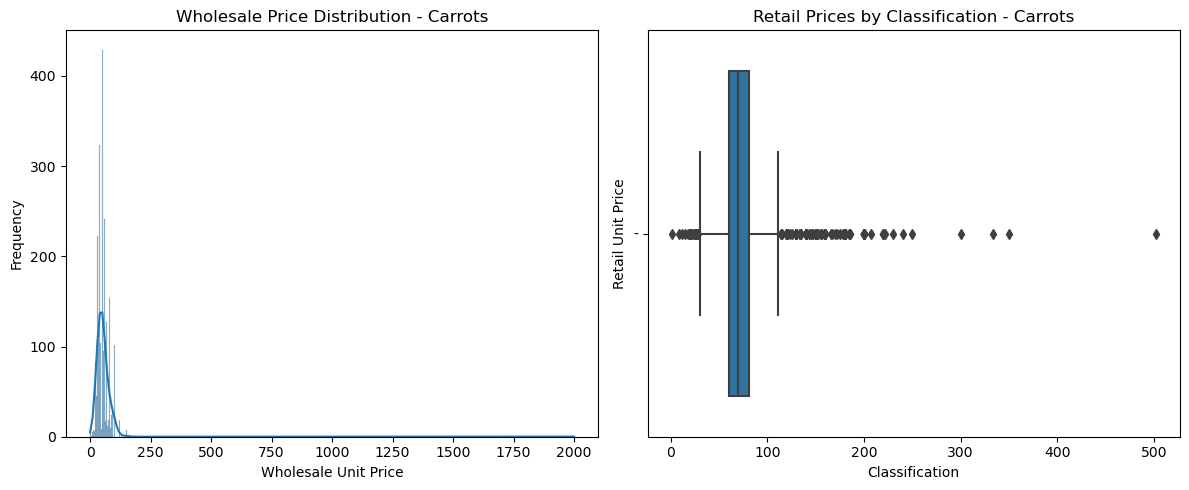

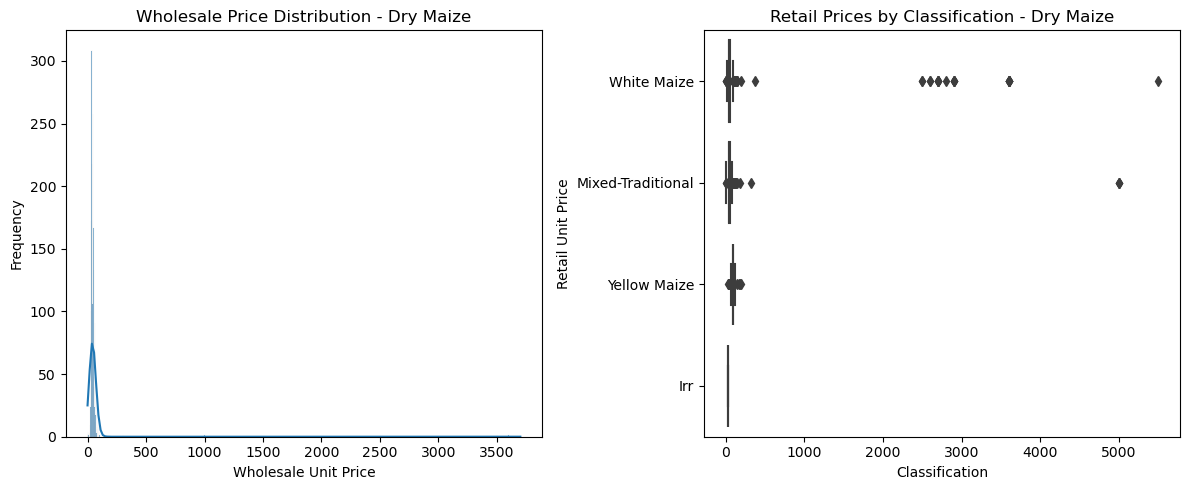

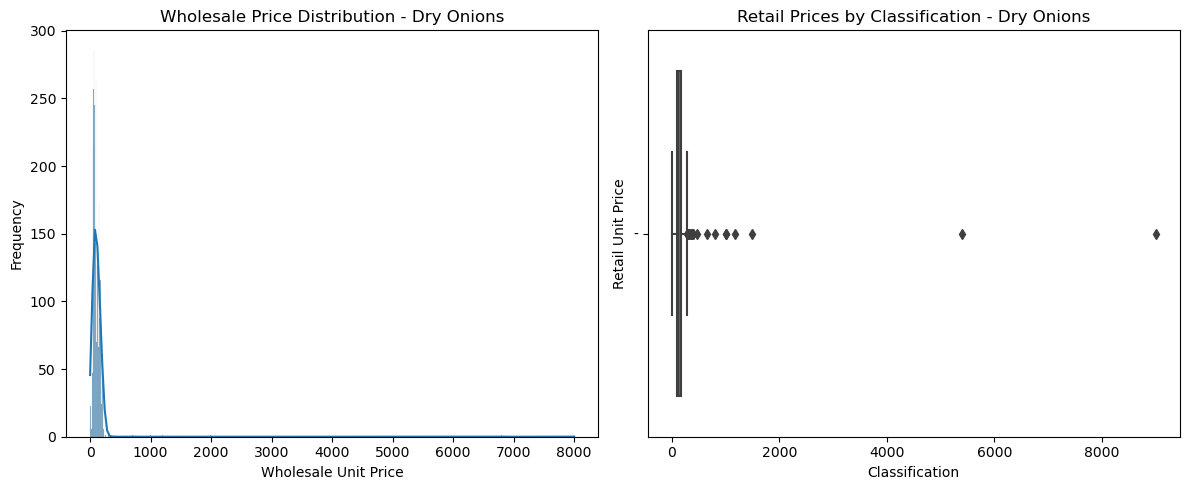

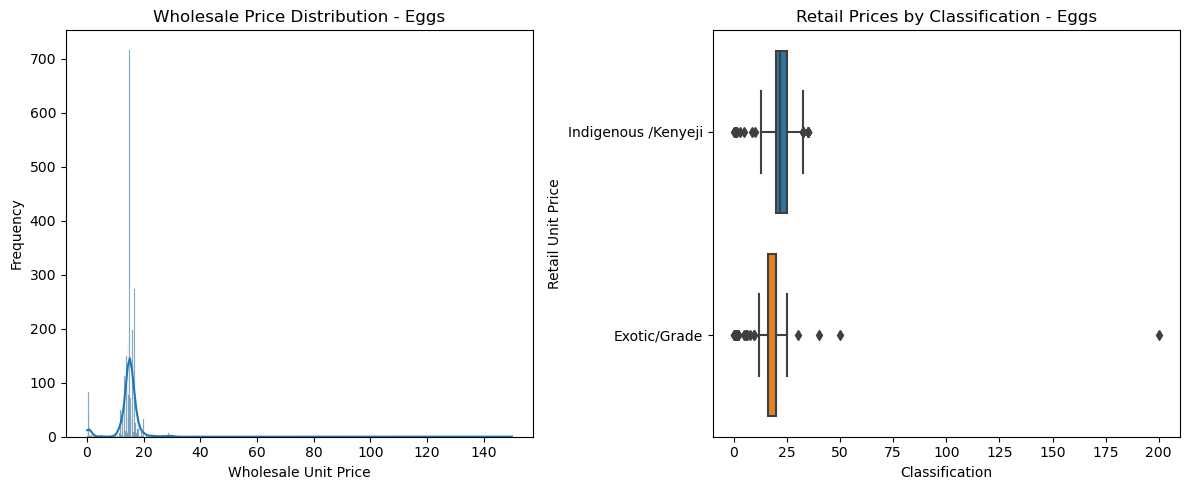

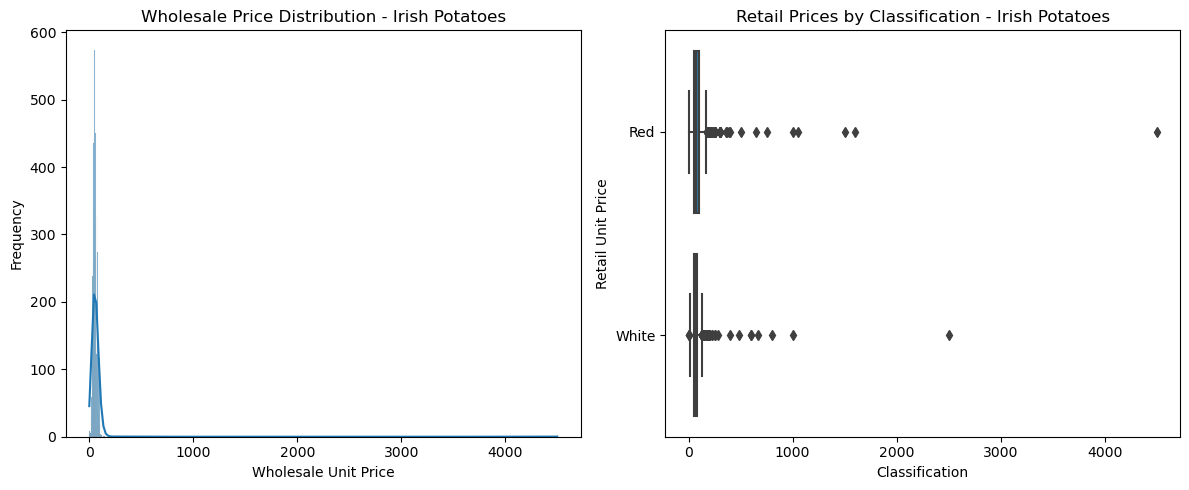

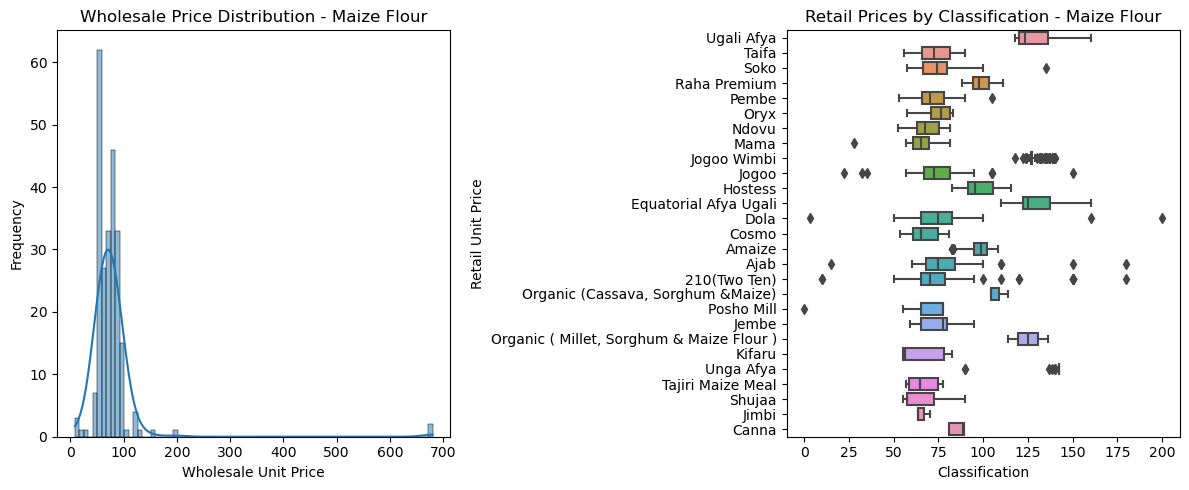

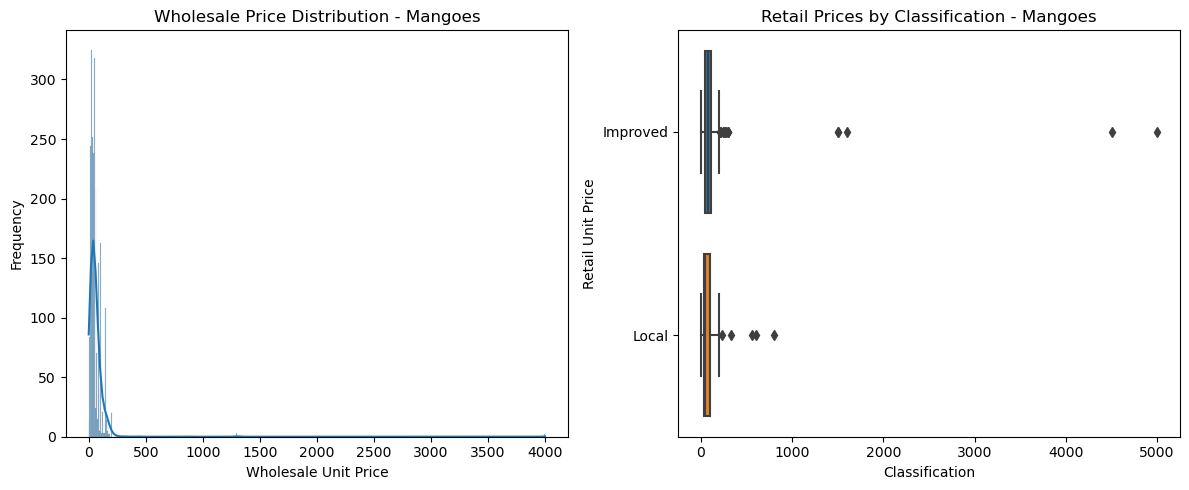

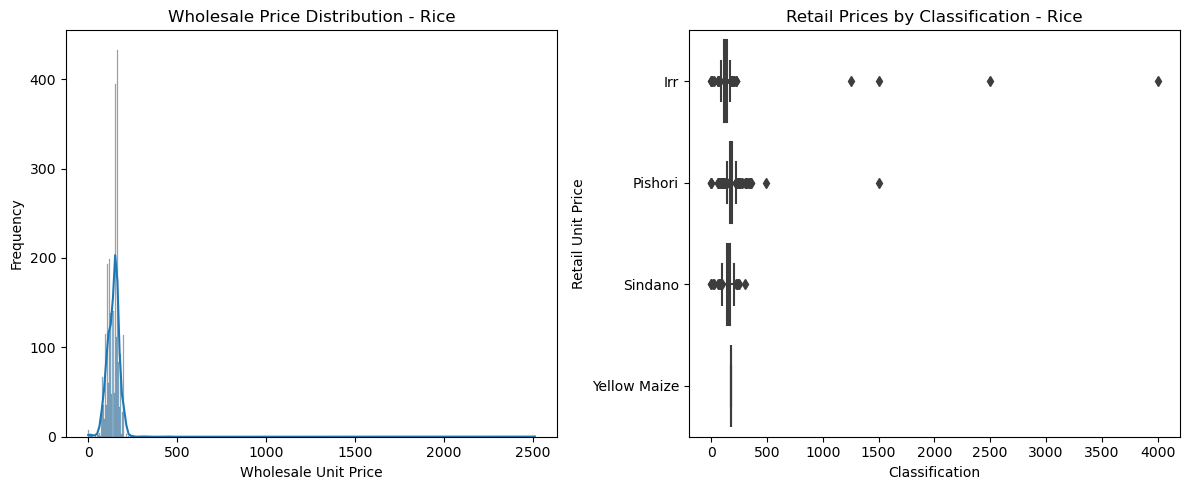

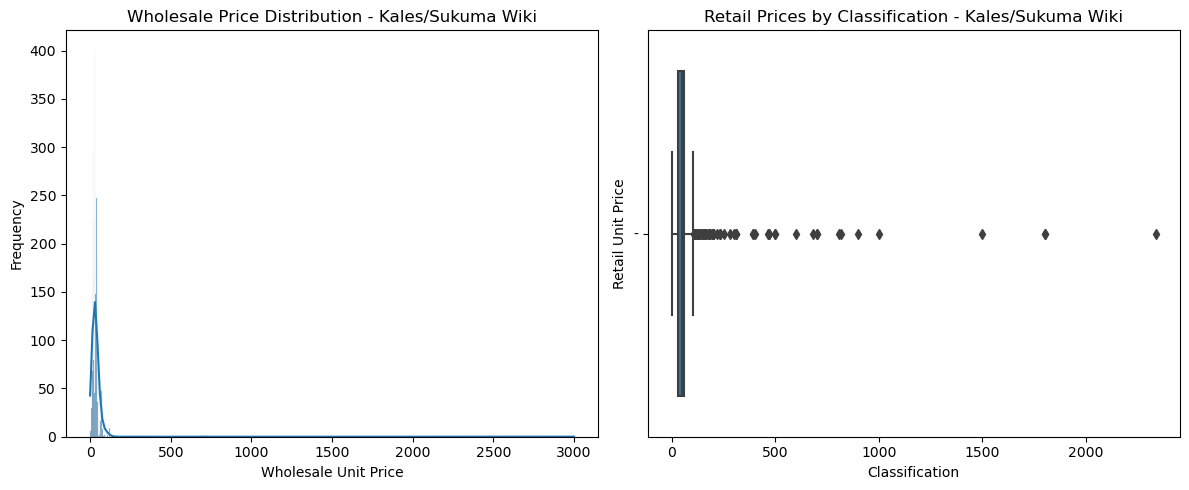

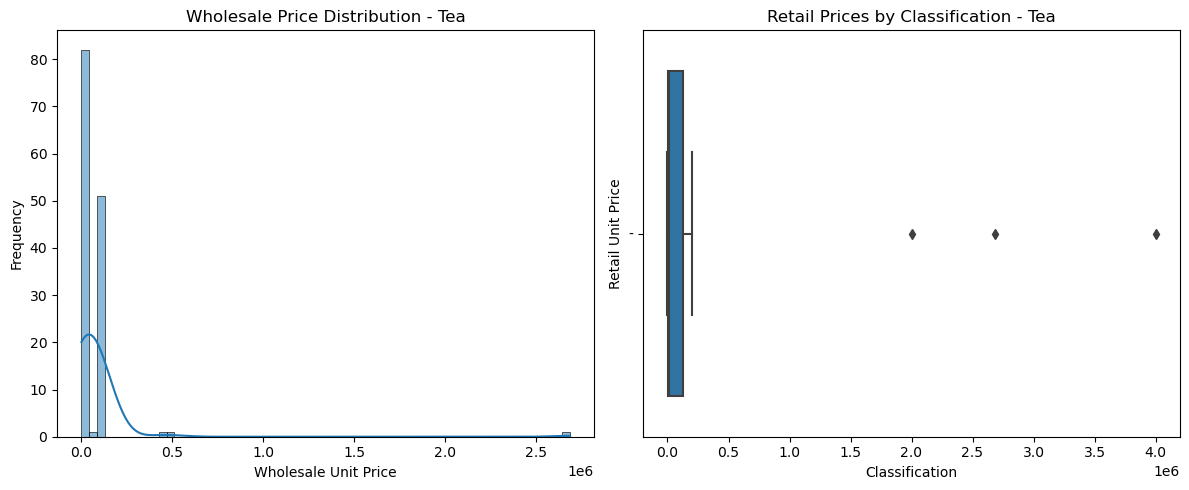

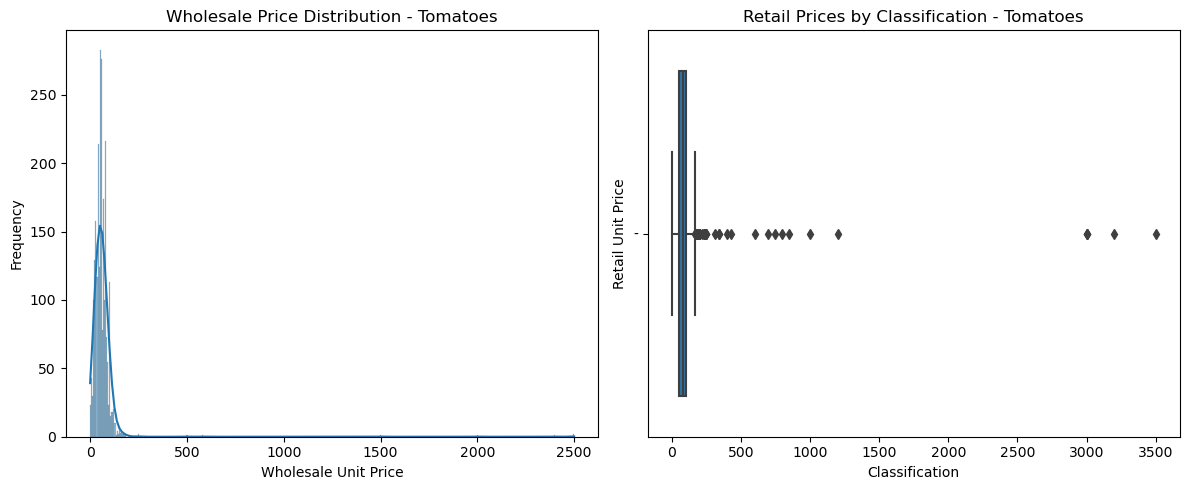

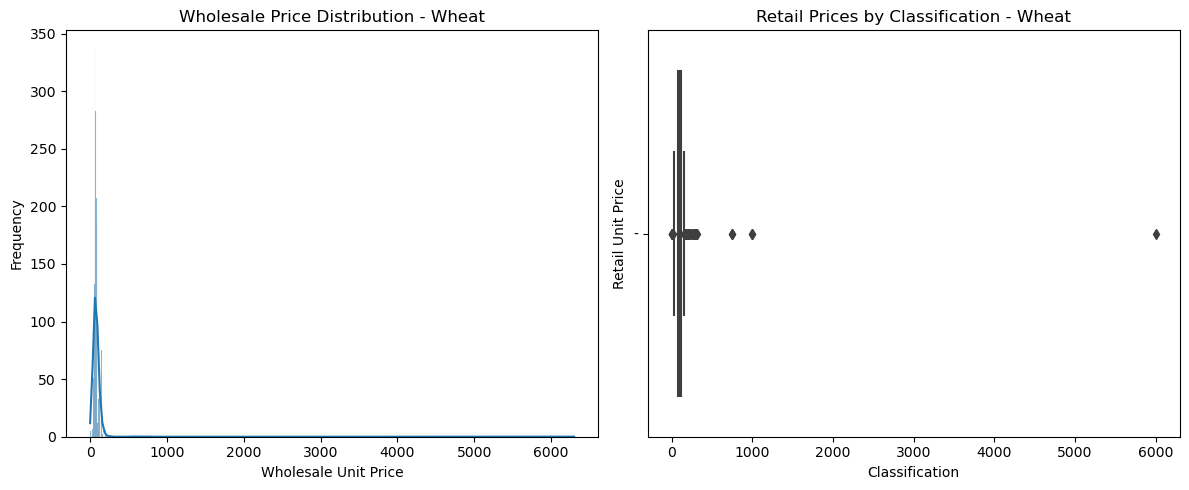

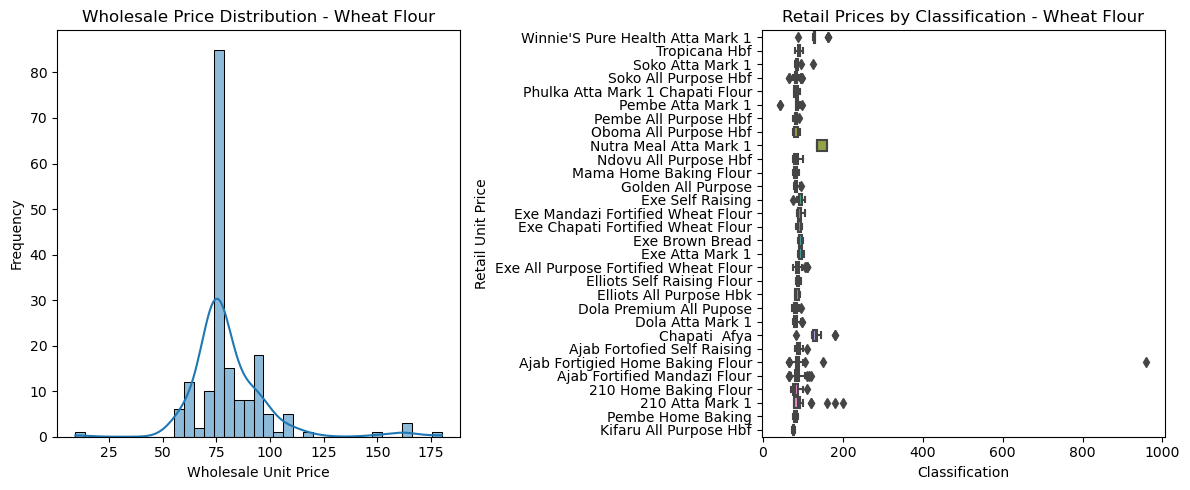

In [14]:
import seaborn as sns
for commodity in df['Commodity'].unique():
    subset = df[df['Commodity'] == commodity]  # Filter for that commodity
    
    # Create side-by-side subplots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # Histogram (Wholesale Prices)
    sns.histplot(subset["WholesaleUnitPrice"], kde=True, ax=axes[0])
    axes[0].set_title(f"Wholesale Price Distribution - {commodity}")
    axes[0].set_xlabel("Wholesale Unit Price")
    axes[0].set_ylabel("Frequency")
    
    # Boxplot (Retail Prices by Classification)
    sns.boxplot(y="Classification", x="RetailUnitPrice", data=subset, ax=axes[1], orient='h')
    axes[1].set_title(f"Retail Prices by Classification - {commodity}")
    axes[1].set_xlabel("Classification")
    axes[1].set_ylabel("Retail Unit Price")
    
    plt.tight_layout()
    plt.show()

### Avocado
**Wholesale Price Distribution** 
- The histogram shows that most wholesale unit prices for Avocados are concentrated at the lower end (near 0–200 KES).

- There are few extreme outliers, with prices going as high as ~4000 KES, but those are rare (long right tail).

- The distribution is highly right-skewed (most data is near the low range, few very high values).

**Retail Prices by Classification**
- The boxplots show retail unit price distributions for different classifications (Fuerte, Hass, Local).

- All three varieties have:

    - Median prices within a similar low-to-mid range, likely between 50–200 KES.

    - Some extreme outliers, especially for Local (prices even above 4000 KES).

- The retail prices show heavy skewness and many outliers, suggesting:

    - Possible reporting errors, 
    - Or rare premium sales/events that are not typical.

**Insights**
- Both wholesale and retail avocado prices are heavily skewed, meaning most sales are cheap, but a few transactions inflate the upper range.

- Retail prices vary by classification but outliers dominate, especially for "Local".

- These outliers could distort averages; median or trimmed means might be better for analysis.

- Could indicate seasonality, reporting inconsistencies, or rare events (bulk sales, premium markets).

### Beans
**Wholesale Price Distribution**
- Most wholesale unit prices are concentrated at the very low end (below ~200 KES).

- The distribution is heavily right-skewed, with prices stretching up to 14,000 KES—these are likely outliers or rare, atypical sales.

- The extreme tail suggests possible:

    - Data entry issues (typos or wrong units),

    - Or special bulk/rare sales inflating the distribution.

**Retail Prices by Classification**
- The boxplots compare retail unit prices for different bean varieties (Mwitemania, Canadian Wonder, Rosecoco, etc.).

- Key observations:

    - Most varieties have retail prices clustered at low values (below 500 KES).

    - There are massive outliers, with some sales hitting 10,000–16,000 KES, far above the usual market range.

    - The median prices are fairly similar across varieties, but outliers dominate the scale, making it hard to see the typical price spread.

**Insights:**
- The data is highly skewed with extreme outliers on both wholesale and retail sides.

- These outliers distort visualization—most prices are small, but the large values push the scale, making the bulk of the data look compressed.

- For proper analysis:

    - Consider removing or capping extreme outliers (Winsorization or IQR filtering).

    - Or use log transformation for visualization so the skew is less extreme.

- The retail price patterns across varieties are generally similar, meaning outliers are likely not specific to one type but systemic.

### Cabbages
**Wholesale Price Distribution**
- Most wholesale prices are heavily concentrated at the low end (under ~100 KES).

- The distribution is right-skewed, with prices reaching up to 3,500 KES, which is highly unusual for cabbages.

- These high-price values are likely:

    - Data entry errors (wrong units or misplaced decimals),

    - Or rare premium/bulk sales.

**Retail Prices by Classification**
- Since there seems to be only one classification, all data is shown in a single boxplot.

- Most retail prices cluster below 100 KES, but there are extreme outliers reaching nearly 1,000 KES.

- The typical range is narrow, but the few large values stretch the plot scale, making the normal data look compressed.

**Insights:**
- Both wholesale and retail cabbage prices are heavily skewed with a few extreme high values.

- These outliers can distort statistical measures (like mean) and visualizations.

- For meaningful analysis:

    - Either remove or cap extreme outliers using IQR filtering or Winsorization,

    - Or use log transformation to visualize without distortion.


### Carrots Wholesale and Retail Prices 

**Observation**

- Wholesale prices are mostly below KES 250 and never go above KES 500.
- Retail prices are scattered from KES 200 all the way up to KES 1,200.
- The biggest gap between retail and wholesale is about KES 1,000.

**Insights**
- Shoppers pay up to 4× more than the farmer’s price.  
- Retailers set very different prices so buyers should compare shops.  
- High retail spread hints at long supply chains or few sellers in some areas.

### Dry Maize Wholesale vs Retail Price

**Observation**
- Wholesale prices stick between KES 50 – 250 
  - White Maize sits at the top (~ 250 KES).  
  - Yellow Maize is cheapest (~ 50 – 100 KES).  
- Retail prices are spread widely from KES 1,000 upto 5,000.  
  - Mixed-Traditional types reach the highest retail tags.

 **Insights**
- Retail is 4× to 20× higher than wholesale as one of the largest mark-ups seen.  
- Yellow Maize offers the lowest entry price for buyers and biggest profit room for sellers.  
- Huge gaps hint at long transport, scarce supply or few traders in some regions.

### Dry Onions Wholesale Vs Retail Price

**Observation**
- Wholesale prices are tightly packed between KES 50 – 350
- Retail prices fan out from KES 2,000 all the way past KES 8,000.
- The widest gap reaches about KES 7,650 (retail 8,000 vs wholesale 50).

 **Insights**
- Buyers pay up to 160× more than the farm-gate price.  
- Extreme mark-up signals long transport routes, storage losses or few sellers in some counties.  
- Wholesale band is narrow so price spikes are not coming from farmers.

### Eggs  Wholesale Vs Retail Price 

**Observation**
- Wholesale prices stay between KES 100 and 700, with two clear groups:
  - Indigenous/Kienyeji eggs sit on the lower end (~100–300).
  - Exotic/Grade eggs cluster higher (~400–700).
- Retail prices spread from KES 25 up to KES 200 per unit.

**Insights**
- Exotic eggs cost about 2–3× more than Indigenous at wholesale and the same gap continues in retail.
- Retail prices overlap a lot so shoppers can find both cheap and expensive eggs in the same market.
- Small wholesale spread but wide retail range suggests sellers set very different profit margins.

### Irish Potatoes Wholesale Vs Retail Price 

**Observations**
- Wholesale prices  
  - Red potatoes: ~200–700 KES  
  - White potatoes: ~100–400 KES  

- Retail prices  
  - Spread from ~1,000 to 4,000 KES for both types  

- Gap  
  - Retail is 3–7× higher than wholesale  

**Insights**
  - Red potatoes start higher at wholesale and stay pricier in shops  
  - Large jump from farm to shelf points to long transport or few middlemen  
  - Buyers of white potatoes can find cheaper deals if they compare markets

### Maize Flour Wholesale Vs Retail Price 

**Observations**

- **Wholesale prices** 
  - Range from ~50 KES (Tajiri Maize Meal, Canna) up to ~350 KES (Ugali Afya, Raha Premium).  
  - Most brands sit between 100–250 KES.  

- **Retail prices**  
  - Spread from ~25 KES to ~200 KES per common unit.  
  - Cheapest retail: Posho Mill, Shujaa, Jimbi.  
  - Costliest retail: Ugali Afya, Raha Premium, Taifa.  

- **Gap**  
  - Mark-up varies as some low-cost brands double in price while premium brands add only ~25–50 KES.  

- **Insights**  
  - Budget brands (Posho Mill, Shujaa) start cheap but still double at retail.  
  - Premium brands (Ugali Afya, Raha) already cost more wholesale and stay high in shops.  
  - Large brand count keeps retail prices competitive—shoppers can save by switching brands.

### Mangoes Wholesale Vs Retail Price

- **Wholesale prices**  
  - Local varieties: ~50 – 150 KES  
  - Improved varieties: ~200 – 350 KES  

- **Retail prices**  
  - Local: ~1,000 – 4,000 KES  
  - Improved: ~2,000 – 5,000 KES  

- **Gap**  
  - Retail is 8 – 15× higher than wholesale  

- **Insights**  
  - Improved mangoes start higher and stay pricier on the shelf. 
  - Huge mark-up suggests long transport, spoilage risk or few sellers  
  - Buyers can find big savings by choosing local varieties when in season

### Rice Wholesale Vs Retail Price 

- **Wholesale prices**  
  - Pishori: ~100–400 KES  
  - Sindano: ~100–300 KES  
  - Yellow Maize likely a data entry error as it  should be another rice type.  

- **Retail prices**  
  - Spread from ~500 KES to ~4,000 KES  

- **Gap**  
  - Retail is 5 – 15× higher than wholesale  

- **Insights**  
  - Pishori has the highest wholesale price but also the widest retail range.  
  - Sindano is mid-range at wholesale but can hit high retail prices.  
  - Big mark-up shows rice is sensitive to transport costs or has few sellers in some areas.  
  - Shoppers can save by comparing brands; sellers can profit by targeting high-end markets with Pishori.

### Kales/Sukuma Wiki Wholesale Vs Retail Price 

- **Wholesale prices**  
  - Most prices are between 0 and 500 KES.  
  - Very few prices above 500 KES.

- **Retail prices**  
  - Range from about 0 to 2,000 KES.  
  - Most prices are between 0 and 500 KES.

- **Gap**  
  - Retail prices are generally higher than wholesale prices.  
  - Some retail prices are significantly higher, up to 4 times the wholesale price.

- **Insights**  
  - The majority of both wholesale and retail transactions happen at lower price points.  
  - There's potential for sellers to increase prices as some are already doing.  
  - Buyers might be able to find good deals by shopping around, as prices vary widely.

### Tea Wholesale Vs Retail Price 

- **Wholesale prices**  
  - Most prices are between 0 and 50 KES.  
  - A few prices are above 50 KES.

- **Retail prices**  
  - Range from about 0 to 400 KES.  
  - Most prices are below 200 KES.

- **Gap**  
  - Retail prices are generally higher than wholesale prices.  
  - Some retail prices are significantly higher up to 4 times the wholesale price.

- **Insights**  
  - The majority of both wholesale and retail transactions happen at lower price points.  
  - There's a wide range in retail prices indicating different types or qualities of tea.  
  - Buyers have options as they can choose cheaper tea or pay more for premium varieties.

### Tomatoes Wholesale Vs Retail Price 

- **Wholesale prices**  
  - Most prices are between 0 and 500 KES.  
  - A few prices are above 500 KES.

- **Retail prices**  
  - Range from about 0 to 3,500 KES.  
  - Most prices are below 500 KES.

- **Gap**  
  - Retail prices are generally higher than wholesale prices.  
  - Some retail prices are significantly higher up to 7 times the wholesale price.

- **Insights**  
  - The majority of both wholesale and retail transactions happen at lower price points.  
  - There's a wide range in retail prices indicating different types or qualities of tomatoes.  
  - Buyers have options as they can choose cheaper tomatoes or pay more for premium varieties.

### Wheat Wholesale Vs Retail Price 

- **Wholesale prices**  
  - Most prices are between 0 and 1,000 KES.  
  - A few prices are above 1,000 KES.

- **Retail prices**  
  - Range from about 0 to 6,000 KES.  
  - Most prices are below 2,000 KES.

- **Gap**  
  - Retail prices are generally higher than wholesale prices.  
  - Some retail prices are significantly higher up to 6 times the wholesale price.

- **Insights**  
  - The majority of both wholesale and retail transactions happen at lower price points.  
  - There's a wide range in retail prices indicating different types or qualities of wheat.  
  - Buyers have options as they can choose cheaper wheat or pay more for premium varieties.

### Wheat Flour Wholesale Vs Retail Price 

- **Wholesale prices**  
  - Most prices are between 25 and 100 KES.  
  - A few prices are above 100 KES.

- **Retail prices**  
  - Range from about 0 to 1,000 KES.  
  - Most prices are below 200 KES.

- **Gap**  
  - Retail prices are generally higher than wholesale prices.  
  - Some retail prices are significantly higher up to 10 times the wholesale price.

- **Insights**  
  - The majority of both wholesale and retail transactions happen at lower price points.  
  - There's a wide range in retail prices indicating different types or qualities of wheat flour.  
  - Buyers have options as they can choose cheaper wheat flour or pay more for premium varieties.  
  - The large number of brands suggests a competitive market with many choices for consumers.

### Remove outliers in the prices.

In [15]:
def remove_outliers(df, columns):
    for column in columns:
        Q1 = df[column].quantile(0.25)
        Q3 = df[column].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[column] >= lower_bound) & (df[column] <= upper_bound)]
    return df

columns = ["WholesaleUnitPrice", "RetailUnitPrice", "ReferencePrice"]
df_clean = remove_outliers(df, columns)

In [16]:
print(df.shape)

print(df_clean.shape)

(61430, 11)
(43206, 11)


In [17]:
df_p = df_clean

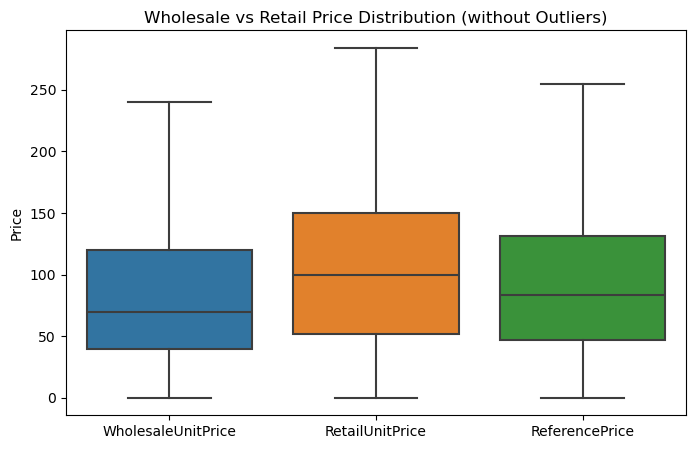

In [18]:
def plot_price_boxplots(df):
    price_cols = ["WholesaleUnitPrice", "RetailUnitPrice","ReferencePrice"]
    
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=df_clean[price_cols])
    plt.title("Wholesale vs Retail Price Distribution (without Outliers)")
    plt.ylabel("Price")
    plt.show()

# Usage
plot_price_boxplots(df)

### Time Series plot of Prices by Month.

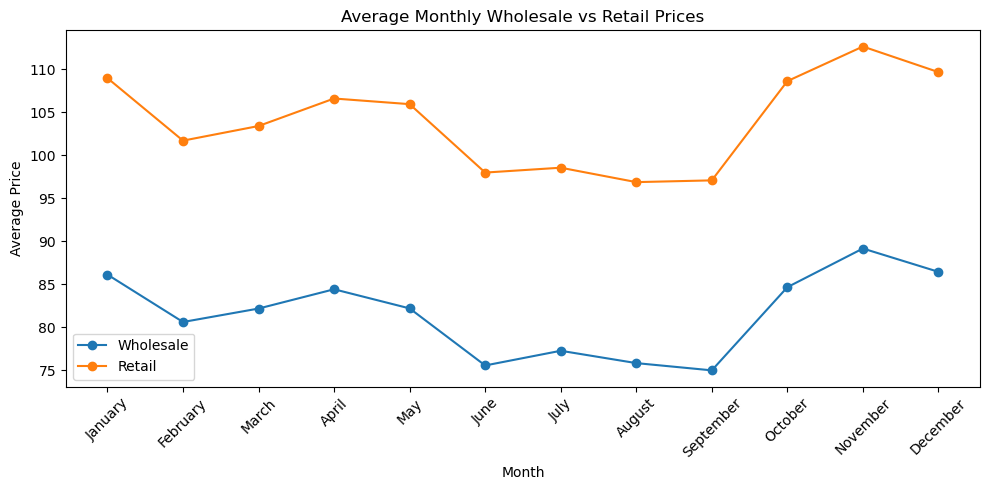

In [19]:
# Define month order
month_order = ["January", "February", "March", "April", "May", "June", 
               "July", "August", "September", "October", "November", "December"]

# Make Month_name an ordered categorical type
df_clean["Month_name"] = pd.Categorical(df_clean["Month_name"], 
                                        categories=month_order, 
                                        ordered=True)

# Group by and compute mean
monthly_prices = df_clean.groupby("Month_name")[["WholesaleUnitPrice", "RetailUnitPrice"]].mean()

# Now it will be sorted correctly
monthly_prices = monthly_prices.sort_index()

# Plot
plt.figure(figsize=(10,5))
plt.plot(monthly_prices.index.astype(str), monthly_prices["WholesaleUnitPrice"], label="Wholesale", marker='o')
plt.plot(monthly_prices.index.astype(str), monthly_prices["RetailUnitPrice"], label="Retail", marker='o')

plt.title("Average Monthly Wholesale vs Retail Prices")
plt.xlabel("Month")
plt.ylabel("Average Price")
plt.xticks(rotation=45)
plt.legend()
plt.tight_layout()
plt.show()



### Observations & Insights

**Observations**

- Retail prices are consistently higher than wholesale prices throughout the year.
- Retail prices show a relatively stable trend with minor fluctuations.
- Wholesale prices exhibit more significant changes with noticeable dips and rises.
- January starts with high prices for both retail and wholesale possibly due to post-holiday demand.
- June to September shows a dip in wholesale prices with the lowest in September likely due to the harvest season.
- October to November sees a sharp increase in prices especially for retail possibly due to pre-holiday demand or reduced supply.
- December shows stabilized prices with a slight dip in retail prices.
- The gap between retail and wholesale prices widens in October and November indicating increased retailer margins during peak demand months.

**Insights for Decision Making**

- Consider buying in bulk during August and September to take advantage of lower wholesale prices.
- Monitor the price gaps between wholesale and retail to adjust retail margins accordingly.
- Seasonal planning is essential for effective procurement, pricing and inventory management especially during periods of high demand or supply fluctuations.

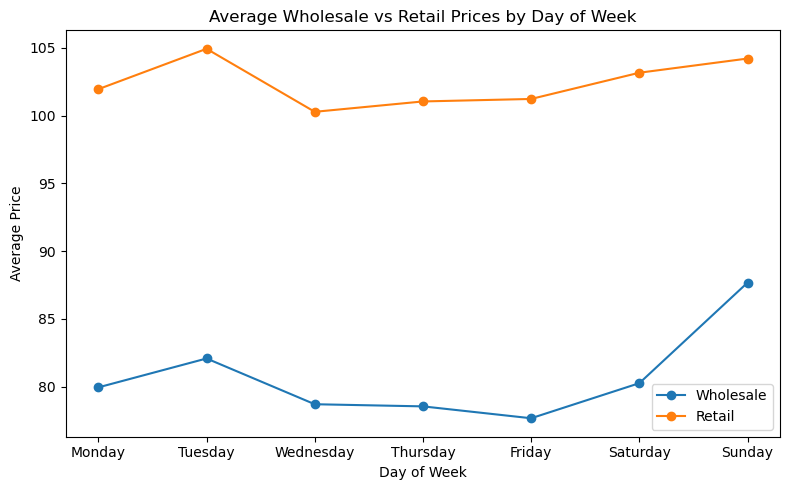

In [20]:
# Aggregate average prices by day of the week
day_prices = df_clean.groupby("Day_Name")[["WholesaleUnitPrice", "RetailUnitPrice"]].mean()

# Ensure correct order of days
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]
day_prices = day_prices.reindex(order)

# Plot
plt.figure(figsize=(8,5))
plt.plot(day_prices.index, day_prices["WholesaleUnitPrice"], label="Wholesale", marker='o')
plt.plot(day_prices.index, day_prices["RetailUnitPrice"], label="Retail", marker='o')

plt.title("Average Wholesale vs Retail Prices by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Average Price")
plt.legend()
plt.tight_layout()
plt.show()

### Observation & Insights

**Observation**

- Retail prices are consistently higher than wholesale prices from Monday to Sunday.
- Retail prices show a slight dip on Wednesday and then remain relatively stable with a slight increase towards the weekend.
- Wholesale prices have more variation with a noticeable drop on Friday and a rise on Sunday.

**Insights**

- The higher retail prices throughout the week compared to wholesale prices suggest retailers are adding a consistent markup to their products.
- The peak in retail prices on Sunday could indicate higher demand or possibly less supply as the week ends leading to higher prices.
- The drop in wholesale prices on Friday might be due to suppliers trying to sell off their stock before the weekend leading to lower prices.
- The retail price curve being smoother than the wholesale curve suggests that retailers might be using strategies to stabilize prices possibly by maintaining consistent markups regardless of wholesale price fluctuations.

### Heat map correlation between WholeSaleUnitPrice and RetailUnitPrice

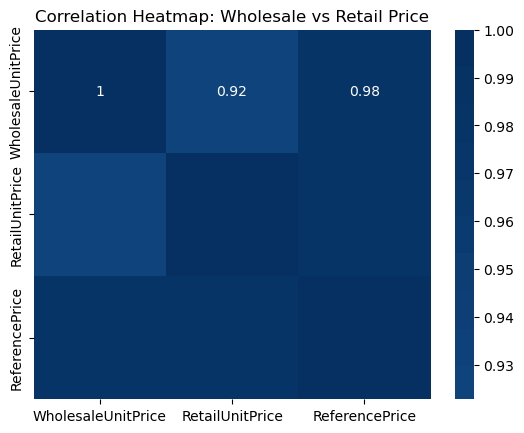

In [21]:
# Correlation matrix
corr = df_clean[["WholesaleUnitPrice", "RetailUnitPrice",'ReferencePrice']].corr()

# Plot heatmap
sns.heatmap(corr, annot=True, cmap="RdBu",alpha= 1.0, center=0)
plt.title("Correlation Heatmap: Wholesale vs Retail Price")
plt.show()

### Correlation Heatmap Analysis

**Observations**

- There is a very strong correlation between WholesaleUnitPrice and RetailUnitPrice with a correlation coefficient of 0.92. This shows that when wholesale prices go up retail prices also tend to increase.
- RetailUnitPrice has a strong correlation with ReferencePrice at 0.98 indicating that retail prices are closely aligned with a reference or standard price.
- WholesaleUnitPrice also correlates highly with ReferencePrice with a coefficient of 1.00 suggesting that wholesale prices are almost identical to the reference price.

**Insights**

- The strong correlations confirm that there is a direct relationship between wholesale and retail prices which is a logical outcome in supply chain management.
- The high correlation between retail and reference prices suggests that retailers use a standard or reference price as a basis for setting their own prices.
- The close match between wholesale and reference prices indicates that the reference price might be set based on wholesale market conditions.
- These correlations can be useful for developing predictive models for pricing as they show that retail and wholesale prices are closely related and can be used as predictors for each other.
- ReferencePrice is being used as a reliable benchmark for assessing pricing strategies and ensuring that retail prices are set competitively and in line with market standards.

### Scatter plot of Wholesale Vs Retail prices by Commodities.

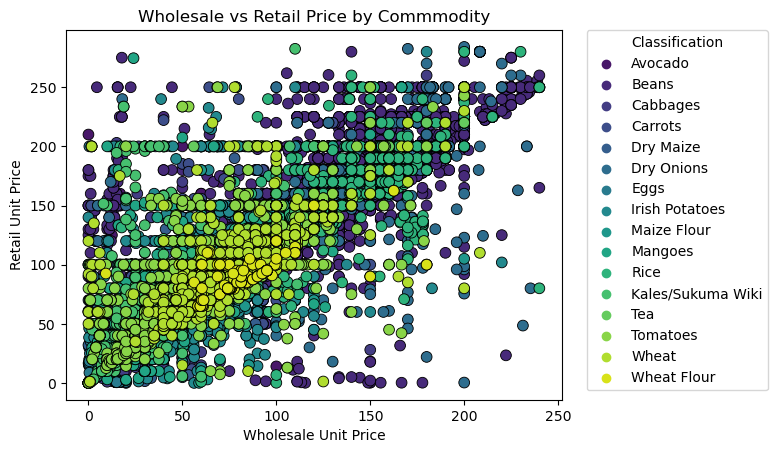

In [22]:
sns.scatterplot(
    x="WholesaleUnitPrice",
    y="RetailUnitPrice",
    hue="Commodity",
    data=df_clean,
    palette="viridis",   
    s=60,                
    edgecolor="black"  
)

plt.title("Wholesale vs Retail Price by Commmodity")
plt.xlabel("Wholesale Unit Price")
plt.ylabel("Retail Unit Price")
plt.legend(title="Classification", bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0)
plt.show()

**Observation**

- Retail prices are consistently higher than wholesale prices for all commodities.
- Some commodities like avocados show a significant increase from wholesale to retail prices.
- Commodities such as tea and kales/sukuma wiki have a smaller increase in price from wholesale to retail.
- The majority of commodities experience at least a 50% increase in price, with some even doubling.

**Insights**

- Retailers generally add a substantial markup to the wholesale prices of all commodities.
- Commodities that have a shorter shelf life or are more perishable tend to have a higher markup to account for potential spoilage and faster turnover.
- Processing raw materials like turning maize into flour can add value and result in a higher profit margin for retailers.
- Less expensive items like tea may have a smaller markup due to their lower cost and potentially higher competition among sellers.

### Price Distributions across Counties.

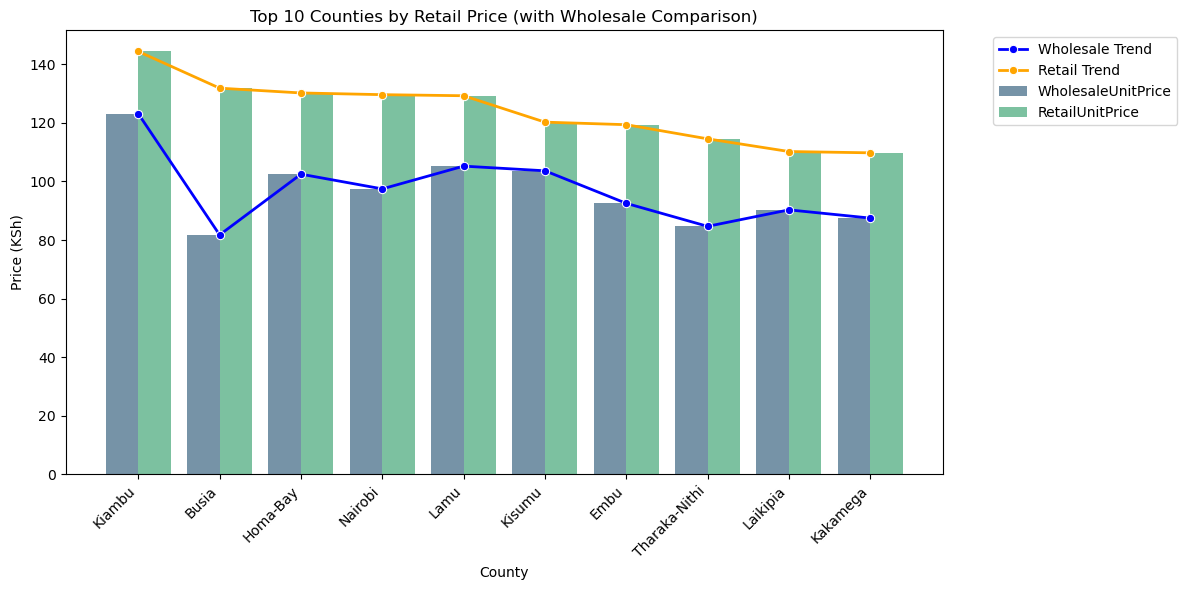

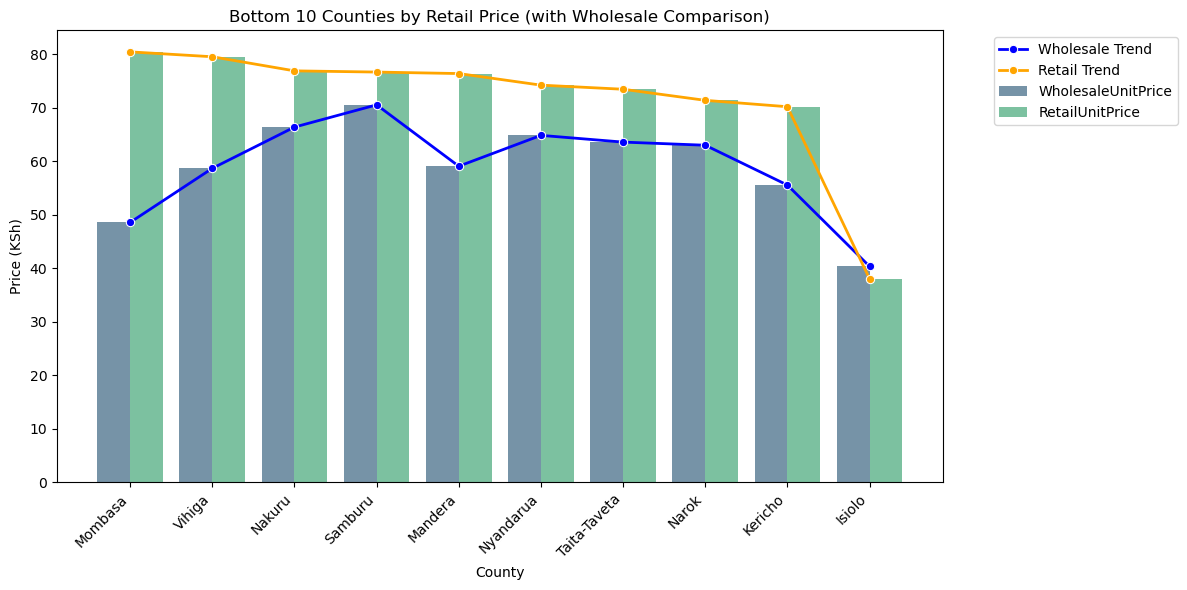

In [23]:
#calculate average prices per county
county_prices = df_clean.groupby("County")[["WholesaleUnitPrice", "RetailUnitPrice"]].mean().reset_index()

# Sort by RetailUnitPrice
sorted_prices = county_prices.sort_values("RetailUnitPrice", ascending=False)

# Get Top 10 and Bottom 10
top10 = sorted_prices.head(10)
bottom10 = sorted_prices.tail(10)

def plot_county_prices(data, title):
    # Melt for grouped bars
    melted = data.melt(
        id_vars="County",
        value_vars=["WholesaleUnitPrice", "RetailUnitPrice"],
        var_name="PriceType", value_name="Price"
    )

    plt.figure(figsize=(12, 6))
    
    # Barplot
    sns.barplot(x="County", y="Price", hue="PriceType", 
                data=melted, palette="viridis", alpha=0.7)
    
    # Line overlays
    sns.lineplot(x="County", y="WholesaleUnitPrice", data=data, 
                 label="Wholesale Trend", color="blue", marker="o", linewidth=2)
    sns.lineplot(x="County", y="RetailUnitPrice", data=data, 
                 label="Retail Trend", color="orange", marker="o", linewidth=2)
    
    plt.title(title)
    plt.xlabel("County")
    plt.ylabel("Price (KSh)")
    plt.xticks(rotation=45, ha="right")
    plt.legend(bbox_to_anchor=(1.05, 1), loc="upper left")
    plt.tight_layout()
    plt.show()

# Plot Top 10
plot_county_prices(top10, "Top 10 Counties by Retail Price (with Wholesale Comparison)")

# Plot Bottom 10
plot_county_prices(bottom10, "Bottom 10 Counties by Retail Price (with Wholesale Comparison)")

### Top 10 Counties by Retail Price (with Wholesale Comparison)

**Observations**
  
- Retail prices are generally higher than wholesale prices across all counties.
- Kiambu has the highest retail price around 140 KES.
- Kajiado has the lowest retail price among the top counties, around 110 KES.
- Wholesale prices show a declining trend as we move down the list of counties.
- There is a noticeable gap between wholesale and retail prices indicating potential areas for profit or cost control.

**Insights**
    
- Counties like Kiambu might have higher operational costs or higher demand driving up retail prices.
- The consistent gap between wholesale and retail prices suggests that sellers across these counties have similar markup strategies.
- Understanding these price differences can help in optimizing supply chain and pricing strategies for better profitability.

### Bottom 10 Counties by Retail Price (with Wholesale Comparison)
    
**Observations**
    
- Retail prices are slightly higher than wholesale prices in these counties.
- The highest retail price is observed in Mombasa around 80 KES.
- The lowest retail price is in Isiolo, approximately 35 KES.
- Wholesale prices are relatively close to retail prices indicating a smaller markup.
- There is less variation in wholesale prices across these counties compared to the top counties.

**Insights**
    
- The smaller gap between wholesale and retail prices suggests lower operational costs or more competitive markets in these areas.
- Sellers in these counties might have lower profit margins, making them more sensitive to changes in wholesale prices.
- For buyers these counties offer relatively lower prices potentially due to better supply chain efficiency or higher competition among sellers.

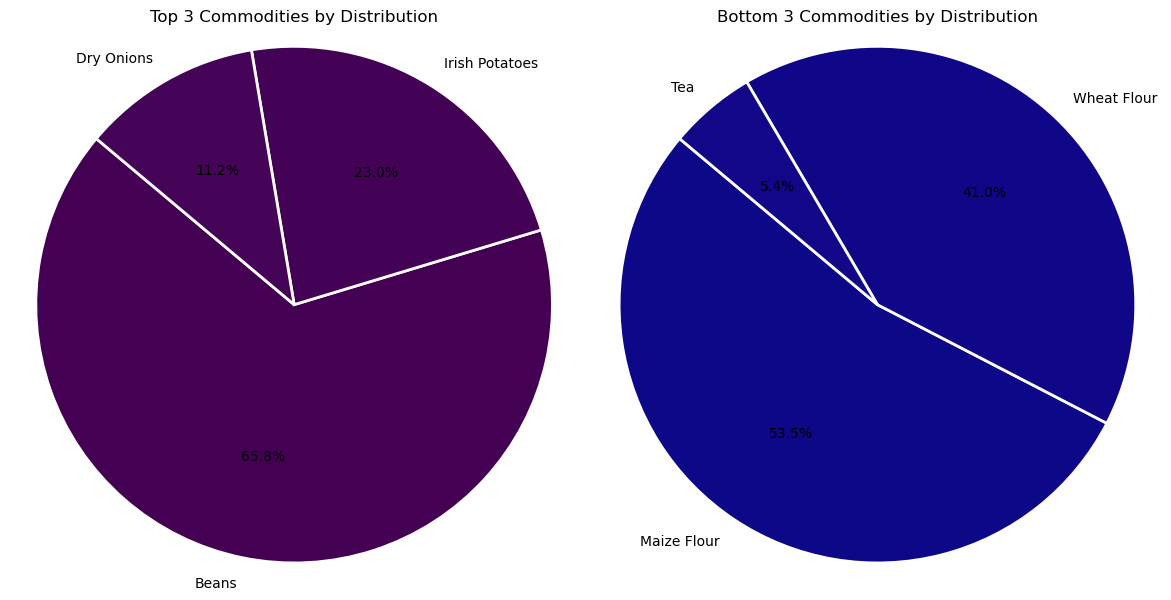

In [24]:

# Count occurrences of commodities
commodity_counts = df_clean["Commodity"].value_counts()

# Top 3 and Bottom 3
top3 = commodity_counts.head(3)
bottom3 = commodity_counts.tail(3)

# subplots for side-by-side charts
fig, axes = plt.subplots(1, 2, figsize=(12, 6))
wedge_props = {'edgecolor': 'white', 'linewidth': 2}
# Top 3 Pie Chart
axes[0].pie(
    top3,
    labels=top3.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.viridis(range(len(top3))),
    wedgeprops=wedge_props
)
axes[0].set_title("Top 3 Commodities by Distribution")
axes[0].axis('equal') 

# Bottom 3 Pie Chart
axes[1].pie(
    bottom3,
    labels=bottom3.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=plt.cm.plasma(range(len(bottom3))),
    wedgeprops=wedge_props
)
axes[1].set_title("Bottom 3 Commodities by Distribution")
axes[1].axis('equal')

plt.tight_layout()
plt.show()

### Top & Bottom 3 Commodities by Distribution

**Observation**

**Top 3 most available**

- Beans – 65.8%
- Irish Potatoes – 23.0%
- Dry Onions – 11.2%

**Bottom 3 least available**

- Maize Flour – 53.5%
- Wheat Flour – 41.0%
- Tea – 5.4%

**Insights**

- Beans dominate the top commodities list indicating they are widely available.
- Irish Potatoes follow as a common staple though less so than Beans.
- Dry Onions are the least available among the top three suggesting a more limited distribution.
- Maize Flour leads the bottom three, showing it is less available compared to other commodities.
- Wheat Flour, while still relatively available is less so than Maize Flour.
- Tea is the least available commodity which could make it more susceptible to supply fluctuations and price changes.

## Modelling

# Feature Engineering

We now engineer the dataset to prepare features for modeling.

## Prediction Targets

We need to predict:
- **WholesaleUnitPrice**
- **RetailUnitPrice** 

These will be treated as two separate targets.

## Feature Engineering Process

We will:

1. **Create lag features** (to include past prices as predictors)
2. **Encode categorical variables**
3. **Drop irrelevant columns**
4. **Split into feature matrix X and targets y_wholesale, y_retail**

## Lag Features

When working with time-series or sequential data, the current value of a variable often depends on its past values.

For example:
- The wholesale price of beans today may be influenced by the price yesterday
- The retail price of tomatoes this week may depend on the wholesale price last week

Lag features capture this dependency by adding past observations as input features for the current prediction.

### How it Works

A lag feature simply shifts the time-series backward by a specified number of time steps.

**Example:**

| Date       | Price |
|------------|-------|
| 2024-01-01 | 100   |
| 2024-01-02 | 110   |
| 2024-01-03 | 105   |

If we create a lag-1 feature (Price_t-1), the dataset becomes:

| Date       | Price | Price_t-1 |
|------------|-------|-----------|
| 2024-01-02 | 110   | 100       |
| 2024-01-03 | 105   | 110       |

### In This Project

We created two lag features:
- **Wholesale_t-1**: Previous wholesale price
- **Retail_t-1**: Previous retail price

These features help our models capture short-term dependencies in price movements, making predictions more accurate.

## Target Transformation

We will also apply **log transformation** to the targets since they are skewed. This helps:
- Normalize the distribution
- Reduce the impact of outliers
- Improve model performance

### BASELINE MODEL PART 1:RIDGE REGRESSION


We begin our modeling with **Ridge Regression** as a baseline. Ridge helps address multicollinearity and penalizes high-magnitude coefficients to prevent overfitting, especially important in datasets with many features or one-hot encodings.

### Data Preparation for Modelling

Before training our model, we perform several preprocessing steps:

- **Sorting and Lag Feature Engineering:**  
  To capture temporal trends, we sort the dataset by date and group, then create lagged features (`Wholesale_t-1` and `Retail_t-1`) to feed past price information into the model.

In [25]:

# Sort for lagging
df_cleaned = df_clean.sort_values(by=["Commodity", "Market", "County", "Date"])

# Lag features
df_cleaned["Wholesale_t-1"] = df_cleaned.groupby(["Commodity", "Market", "County"])["WholesaleUnitPrice"].shift(1)
df_cleaned["Retail_t-1"] = df_cleaned.groupby(["Commodity", "Market", "County"])["RetailUnitPrice"].shift(1)
df = df_cleaned.dropna()


### Outlier Removal, One-Hot Encoding, and Target Transformation
We continue preparing the dataset by:

- **Removing Extreme Outliers:**  
  Cap the prices at the 1st and 99th percentiles to reduce skew caused by extreme values.

- **One-Hot Encoding:**  
  Convert categorical features (like Commodity and Market) into binary features to make them usable in the regression model.

- **Log Transforming Targets:**  
  Apply `log1p` to the wholesale and retail prices to stabilize variance and handle skewed distributions.s

In [26]:
# Remove extreme outliers
low_cap = 1
high_cap_wholesale = df["WholesaleUnitPrice"].quantile(0.99)
high_cap_retail = df["RetailUnitPrice"].quantile(0.99)
df = df[(df["WholesaleUnitPrice"] >= low_cap) & (df["RetailUnitPrice"] >= low_cap)]
df = df[(df["WholesaleUnitPrice"] <= high_cap_wholesale) & (df["RetailUnitPrice"] <= high_cap_retail)]


# One-hot encode categoricals
categoricals = ["Commodity", "Classification", "County", "Market", "Month_name", "Day_Name"]
df_encoded = pd.get_dummies(df, columns=categoricals, drop_first=True)

# Targets (log-transformed for stability)
y_wholesale = np.log1p(df_encoded["WholesaleUnitPrice"])
y_retail = np.log1p(df_encoded["RetailUnitPrice"])

# Features
drop_cols = ["Date", "WholesaleUnitPrice", "RetailUnitPrice", "ReferencePrice"]
X = df_encoded.drop(columns=drop_cols)
X_df = pd.DataFrame(X, index=df_encoded.index)


### Train-Test Split & Feature Scaling

We split the data into training and testing sets (80/20) for both wholesale and retail price models.

**Scaling**

 Since Ridge regression is sensitive to feature magnitudes, we apply **standard scaling** (`StandardScaler`) after the split to avoid data leakage

In [27]:
#  Train-Test Split (with index tracking)
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_df, y_wholesale, test_size=0.2, random_state=42)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_df, y_retail, test_size=0.2, random_state=42)

# Scale features
scaler = StandardScaler()
X_train_w_scaled = scaler.fit_transform(X_train_w)
X_test_w_scaled = scaler.transform(X_test_w)
X_train_r_scaled = scaler.fit_transform(X_train_r)
X_test_r_scaled = scaler.transform(X_test_r)


### Hyperparameter Tuning with RidgeCV

We use **RidgeCV** to automatically select the best alpha (regularization strength) through cross-validation.

- A range of alpha values (log-spaced from 0.001 to 1000) is tested.
- The model fits the training data and selects the optimal value based on cross-validation performance.

In [28]:
#  RidgeCV (Hyperparameter tuning)
alphas = np.logspace(-3, 3, 50)

ridge_cv_wholesale = RidgeCV(alphas=alphas, cv=5)
ridge_cv_retail = RidgeCV(alphas=alphas, cv=5)

ridge_cv_wholesale.fit(X_train_w_scaled, y_train_w)
ridge_cv_retail.fit(X_train_r_scaled, y_train_r)

print(f"Best alpha (Wholesale): {ridge_cv_wholesale.alpha_}")
print(f"Best alpha (Retail): {ridge_cv_retail.alpha_}")

# Predictions (back to KES scale)
y_pred_w = np.expm1(ridge_cv_wholesale.predict(X_test_w_scaled))
y_pred_r = np.expm1(ridge_cv_retail.predict(X_test_r_scaled))
y_test_w_orig = np.expm1(y_test_w)
y_test_r_orig = np.expm1(y_test_r)


Best alpha (Wholesale): 184.20699693267164
Best alpha (Retail): 59.636233165946365


### Error analysis by county and commodity

To gain a deeper understanding of our model’s prediction performance, we conduct an error analysis grouped by **Commodity** and **County**:

- Create a results DataFrame comparing actual vs. predicted values for both wholesale and retail prices.
- Join this with the original group labels (Commodity, County).
- Compute the **prediction error** as the difference between predicted and actual values.
- Aggregate the errors using `groupby()` to find the **average prediction error** per commodity and county.

This helps identify where our model systematically **overestimates** or **underestimates** prices, key for guiding model improvements and flagging specific market dynamics.

In [29]:
# Error Analysis (by Commodity & County)
results_df = pd.DataFrame({
    "Actual_Wholesale": y_test_w_orig,
    "Pred_Wholesale": y_pred_w,
    "Actual_Retail": y_test_r_orig,
    "Pred_Retail": y_pred_r
}, index=X_test_w.index)

# Join original group labels
results_df = results_df.join(df[["Commodity", "County"]])

# Compute errors
results_df["Wholesale_Error"] = results_df["Pred_Wholesale"] - results_df["Actual_Wholesale"]
results_df["Retail_Error"] = results_df["Pred_Retail"] - results_df["Actual_Retail"]

# Summarize by group
error_summary = results_df.groupby(["Commodity", "County"])[["Wholesale_Error", "Retail_Error"]].mean()


### Model Evaluation: Metrics

We assess model performance using:

- **Mean Squared Error (MSE)** – Measures average squared error.
- **R² Score** – Indicates the proportion of variance explained by the model.

In [30]:
# Metrics
mse_w = mean_squared_error(y_test_w_orig, y_pred_w)
mse_r = mean_squared_error(y_test_r_orig, y_pred_r)
r2_w = r2_score(y_test_w_orig, y_pred_w)
r2_r = r2_score(y_test_r_orig, y_pred_r)

print(f"Wholesale MSE: {mse_w:.2f}, R²: {r2_w:.4f}")
print(f"Retail MSE: {mse_r:.2f}, R²: {r2_r:.4f}")


Wholesale MSE: 500.84, R²: 0.7850
Retail MSE: 704.32, R²: 0.7790


These are strong baseline results, suggesting our model captures a significant portion of the price variation.

### Identifying Top Overestimations and Underestimations
We sort the grouped error values to reveal where the model's predictions deviate the most:

- **Overestimations:** Where predicted prices are significantly higher than actual prices.
- **Underestimations:** Where predicted prices are significantly lower than actual prices.

We display the **top 10** cases for both wholesale and retail price predictions.

These insights help pinpoint areas where price volatility, insufficient features, or market anomalies may be impacting model accuracy, and where further refinement (e.g., location-specific adjustments or additional features) may be neceary. 
essary.
ection).

In [31]:
# Sort and display top overestimations
print("\nTop 10 Overestimations (Wholesale):")
print(error_summary.sort_values(by="Wholesale_Error", ascending=False).head(10))

print("\nTop 10 Overestimations (Retail):")
print(error_summary.sort_values(by="Retail_Error", ascending=False).head(10))



Top 10 Overestimations (Wholesale):
                          Wholesale_Error  Retail_Error
Commodity   County                                     
Rice        Kisii               94.840987    286.435716
Beans       Garissa             88.050464     94.206223
Wheat       Siaya               60.398434    152.354299
Rice        Kilifi              59.096366     58.824800
Maize Flour Kakamega            48.502019     49.355801
            Nandi               43.011909     40.709170
Beans       Tana-River          32.043559     67.526660
Rice        Taita-Taveta        31.056484     14.931256
            Meru                25.479767     14.750780
            Tana-River          23.547252     16.912627

Top 10 Overestimations (Retail):
                        Wholesale_Error  Retail_Error
Commodity   County                                   
Rice        Kisii             94.840987    286.435716
Wheat       Siaya             60.398434    152.354299
Beans       Garissa           88.050464  

In [32]:

# Sort and display top underestimations
print("\nTop 10 Underestimations (Wholesale):")
print(error_summary.sort_values(by="Wholesale_Error", ascending=True).head(10))

print("\nTop 10 Underestimations (Retail):")
print(error_summary.sort_values(by="Retail_Error", ascending=True).head(10))



Top 10 Underestimations (Wholesale):
                          Wholesale_Error  Retail_Error
Commodity  County                                      
Tea        Uasin-Gishu         -45.316470    -46.573909
Avocado    Lamu                -41.620867    -42.042864
Wheat      Taita-Taveta        -41.093198    -25.526005
Tomatoes   Tana-River          -38.237687    -26.135669
Avocado    Tana-River          -32.896199     -7.623530
Carrots    Kisii               -29.563084    -23.039765
Avocado    Kisumu              -29.521318    -49.715618
Rice       Tharaka-Nithi       -27.952917    -25.125234
Dry Onions Nyamira             -27.265990    -38.688600
Tomatoes   Trans-Nzoia         -25.316067    -24.796633

Top 10 Underestimations (Retail):
                         Wholesale_Error  Retail_Error
Commodity   County                                    
Avocado     Kisumu            -29.521318    -49.715618
Tea         Uasin-Gishu       -45.316470    -46.573909
Mangoes     Laikipia           -0.5

### BASELINE MODEL 2:XGBOOST

DATA PREPARATION FOR XGBOOST

### Creating Lag Features

We sort the dataset by `Commodity`, `Market`, `County`, and `Date` to ensure proper time order.   
We then generate lag features for both wholesale and retail unit prices by shifting the previous day's price (`t-1`) within each group.  
This allows the model to learn from past pricing behavior to predict future prices.

After shifting, we drop any rows with missing values caused by the lag operation.

In [33]:
# Sort for lagging
df_cleaned = df_clean.sort_values(by=["Commodity", "Market", "County", "Date"])

# Lag features
df_cleaned["Wholesale_t-1"] = df_cleaned.groupby(["Commodity", "Market", "County"])["WholesaleUnitPrice"].shift(1)
df_cleaned["Retail_t-1"] = df_cleaned.groupby(["Commodity", "Market", "County"])["RetailUnitPrice"].shift(1)
df = df_cleaned.dropna()


### Data Cleaning & Preparation 

We cleaned the data in four main steps:

1. **Remove Outliers**  
   - Dropped prices < 1.  
   - Capped data at the 99th percentile for `WholesaleUnitPrice` and `RetailUnitPrice`.

2. **Encode Categorical Variables**  
   - Applied one-hot encoding to columns like `Commodity`, `County`, `Market`, etc.  
   - Used `drop_first=True` to prevent multicollinearity.

3. **Log-Transform Targets**  
   - Applied `np.log1p()` to skewed price columns to improve model performance:  
     - `WholesaleUnitPrice` → `y_wholesale`  
     - `RetailUnitPrice` → `y_retail`

4. **Define Final Features**  
   - Dropped `Date`, target columns, and `ReferencePrice`.  
   - Final feature set stored in `X_df`, preerving the index.


In [34]:
# Remove extreme outliers
low_cap = 1
high_cap_wholesale = df["WholesaleUnitPrice"].quantile(0.99)
high_cap_retail = df["RetailUnitPrice"].quantile(0.99)
df = df[(df["WholesaleUnitPrice"] >= low_cap) & (df["RetailUnitPrice"] >= low_cap)]
df = df[(df["WholesaleUnitPrice"] <= high_cap_wholesale) & (df["RetailUnitPrice"] <= high_cap_retail)]


# One-hot encode categoricals
categoricals = ["Commodity", "Classification", "County", "Market", "Month_name", "Day_Name"]
df_encoded = pd.get_dummies(df, columns=categoricals, drop_first=True)


# Log-transform targets for stability
y_wholesale = np.log1p(df_encoded["WholesaleUnitPrice"])
y_retail = np.log1p(df_encoded["RetailUnitPrice"])

# Features
drop_cols = ["Date", "WholesaleUnitPrice", "RetailUnitPrice", "ReferencePrice"]
X = df_encoded.drop(columns=drop_cols)
X_df = pd.DataFrame(X, index=df_encoded.index)  # Keep index for later # Keep index for later



### Train-Test Split Summary 

We split the features (`X_df`) and log-transformed target variables into training and testing sets to prepare for model building.

- **Wholesale Price**  
  `X_train_w`, `X_test_w`, `y_train_w`, `y_test_w`

- **Retail Price**  
  `X_train_r`, `X_test_r`, `y_train_r`, `y_test_r`

80% used for training   
20% held out for testing   
`random_state=42` ensures reproducibility oducibility


In [35]:
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X_df, y_wholesale, test_size=0.2, random_state=42)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X_df, y_retail, test_size=0.2, random_state=42)

### Train XGBoost Models for wholesale and retail


In [36]:
# Wholesale model
xgb_w = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method="hist"  # for speed
)
xgb_w.fit(X_train_w, y_train_w)

# Retail model
xgb_r = XGBRegressor(
    n_estimators=500,
    learning_rate=0.05,
    max_depth=6,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42,
    tree_method="hist"
)
xgb_r.fit(X_train_r, y_train_r)


XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             feature_weights=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.05, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=500,
             n_jobs=None, num_parallel_tree=None, ...)

### PREDICT AND EVALUATE THE RESULTS FOR THE BOTH MODELS

After training, we made predictions on the test sets and **converted the log-transformed outputs back to KES** using `np.expm1()`.

#### Model Evaluation
We evaluated model performance using:

- **Mean Squared Error (MSE)**: Measures the average squared difference between predicted and actual values.
- **R² Score**: Indicates how well the model explains the variance in the data (closer to 1 is better).

In [37]:
#Predictions (Back to KES)
y_pred_w = np.expm1(xgb_w.predict(X_test_w))
y_pred_r = np.expm1(xgb_r.predict(X_test_r))
y_test_w_orig = np.expm1(y_test_w)
y_test_r_orig = np.expm1(y_test_r)

# Evaluation
mse_w = mean_squared_error(y_test_w_orig, y_pred_w)
mse_r = mean_squared_error(y_test_r_orig, y_pred_r)
r2_w = r2_score(y_test_w_orig, y_pred_w)
r2_r = r2_score(y_test_r_orig, y_pred_r)

print(f"XGBoost Wholesale MSE: {mse_w:.2f}, R²: {r2_w:.4f}")
print(f"XGBoost Retail MSE: {mse_r:.2f}, R²: {r2_r:.4f}")

XGBoost Wholesale MSE: 270.67, R²: 0.8838
XGBoost Retail MSE: 368.59, R²: 0.8844


### HYPER PARAMETER TUNING THE XGBOOST FOR BETTER PERFORMANCE

In [38]:
#xgboost tuning
from sklearn.model_selection import RandomizedSearchCV
def tune_xgb(X_train, y_train):
    xgb = XGBRegressor(tree_method="hist", random_state=42)

    param_dist = {
        "n_estimators": [200, 400, 600],
        "max_depth": [3, 5, 7, 9],
        "learning_rate": [0.01, 0.05, 0.1],
        "subsample": [0.6, 0.8, 1.0],
        "colsample_bytree": [0.6, 0.8, 1.0],
        "gamma": [0, 1, 5],
        "min_child_weight": [1, 3, 5]
    }

    search = RandomizedSearchCV(
        xgb,
        param_distributions=param_dist,
        n_iter=20,  # 20 random combinations
        scoring="neg_mean_squared_error",
        cv=3,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )

    search.fit(X_train, y_train)
    return search.best_estimator_, search.best_params_

# Tune and Train Models
best_xgb_w, params_w = tune_xgb(X_train_w, y_train_w)
best_xgb_r, params_r = tune_xgb(X_train_r, y_train_r)

print("Best params for Wholesale:", params_w)
print("Best params for Retail:", params_r)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params for Wholesale: {'subsample': 1.0, 'n_estimators': 400, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}
Best params for Retail: {'subsample': 1.0, 'n_estimators': 400, 'min_child_weight': 5, 'max_depth': 5, 'learning_rate': 0.1, 'gamma': 0, 'colsample_bytree': 0.8}


### XGBoost Hyperparameter Tuning Summary 

During model tuning using `RandomizedSearchCV`, the training process involved evaluating **20 different combinations of hyperparameters**, using **3-fold cross-validation** for each. This resulted in a total of:

- **60 fits per model** (20 combinations × 3 folds)



### Best Hyperparameters Found 

After completing the tuning process, the following hyperparameter combinations gave the best performance (lowest MSE during cross-validation) for both models:

#### Wholesale Model 
```json
{
  "subsample": 1.0,
  "n_estimators": 400,
  "min_child_weight": 5,
  "max_depth": 5,
  "learning_rate": 0.1,
  "gamma": 0,
  "colsample_bytree": 0.8
}
```

#### Retail Model 
```json
{
  "subsample": 1.0,
  "n_estimators": 400,
  "min_child_weight": 5,
  "max_depth": 5,
  "learning_rate": 0.1,
  "gamma": 0,
  "colsample_bytree": 0.8
}
```



### Insight 

Both models converged to the same optimal hyperparameters suggesting that **similar tree structures** and **regularization levels** work well for predicting both wholesale and retail sales in this dataset. 

This is a good sign of **consistency in feature patterns** across both prediction targets.



### Predict and Evaluate


After tuning the XGBoost models for Wholesale and Retail sales predictions, we evaluated their performance on the test data

In [39]:
y_pred_w = np.expm1(best_xgb_w.predict(X_test_w))
y_pred_r = np.expm1(best_xgb_r.predict(X_test_r))
y_test_w_orig = np.expm1(y_test_w)
y_test_r_orig = np.expm1(y_test_r)

mse_w = mean_squared_error(y_test_w_orig, y_pred_w)
mse_r = mean_squared_error(y_test_r_orig, y_pred_r)
r2_w = r2_score(y_test_w_orig, y_pred_w)
r2_r = r2_score(y_test_r_orig, y_pred_r)

print(f"Tuned XGBoost Wholesale MSE: {mse_w:.2f}, R²: {r2_w:.4f}")
print(f"Tuned XGBoost Retail MSE: {mse_r:.2f}, R²: {r2_r:.4f}")

Tuned XGBoost Wholesale MSE: 268.60, R²: 0.8847
Tuned XGBoost Retail MSE: 372.60, R²: 0.8831


The target variables had been log-transformed earlier using `np.log1p()` to stabilize variance and improve model learning. Therefore, we had to **reverse the transformation** before evaluating predictions.


An R² of ~0.88 indicates that the model explains about **88% of the variation** in both Wholesale and Retail sales.


## Add Seasonality for XGBOOST to learn the patterns better.

### What this adds compared to the previous model
1. Lagged features (t-1) – captures autocorrelation (yesterday’s prices affect today’s).

2. Rolling averages (MA7, MA30) – smooth trends and seasonality.

3. Month, WeekOfYear, DayOfWeek – captures seasonal effects (harvest cycles, market trends).

4. Still uses XGBoost tuning to find optimal tree settings.



In [40]:
# Sort Data & Create Time Features
# Rolling averages (captures short- and medium-term trends)
# Weekly (7-day) and monthly (30-day) rolling averages per commodity/market/county
df["Wholesale_MA7"] = df.groupby(["Commodity", "Market", "County"])["WholesaleUnitPrice"].transform(
    lambda x: x.rolling(7, min_periods=1).mean()
)
df["Retail_MA7"] = df.groupby(["Commodity", "Market", "County"])["RetailUnitPrice"].transform(
    lambda x: x.rolling(7, min_periods=1).mean()
)
df["Wholesale_MA30"] = df.groupby(["Commodity", "Market", "County"])["WholesaleUnitPrice"].transform(
    lambda x: x.rolling(30, min_periods=1).mean()
)
df["Retail_MA30"] = df.groupby(["Commodity", "Market", "County"])["RetailUnitPrice"].transform(
    lambda x: x.rolling(30, min_periods=1).mean()
)

# Seasonal indicators (for cyclical patterns)
df["Month"] = pd.to_datetime(df["Date"]).dt.month            # Month (1–12)
df["WeekOfYear"] = pd.to_datetime(df["Date"]).dt.isocalendar().week.astype(int)  # Week (1–52)
df["DayOfWeek"] = pd.to_datetime(df["Date"]).dt.dayofweek     # 0=Monday, 6=Sunday

# Dropping rows with NaN from lagging 
df = df.dropna()


### Train-Test Split


In [41]:
X_train_w, X_test_w, y_train_w, y_test_w = train_test_split(X, y_wholesale, test_size=0.2, random_state=42)
X_train_r, X_test_r, y_train_r, y_test_r = train_test_split(X, y_retail, test_size=0.2, random_state=42)


### Tune XGBoost (Random Search)


In [42]:
def tune_xgb(X_train, y_train):
    xgb = XGBRegressor(tree_method="hist", random_state=42)

    param_dist = {
        "n_estimators": [300, 500, 700],
        "max_depth": [5, 7, 9],
        "learning_rate": [0.01, 0.05, 0.1],
        "subsample": [0.7, 0.8, 1.0],
        "colsample_bytree": [0.7, 0.8, 1.0],
        "gamma": [0, 1, 5],
        "min_child_weight": [1, 3, 5]
    }

    search = RandomizedSearchCV(
        xgb,
        param_distributions=param_dist,
        n_iter=20,  # 20 random combinations
        scoring="neg_mean_squared_error",
        cv=3,
        verbose=1,
        n_jobs=-1,
        random_state=42
    )
    search.fit(X_train, y_train)
    return search.best_estimator_, search.best_params_

# Tune both models
best_xgb_w, params_w = tune_xgb(X_train_w, y_train_w)
best_xgb_r, params_r = tune_xgb(X_train_r, y_train_r)

print("Best params (Wholesale):", params_w)
print("Best params (Retail):", params_r)


Fitting 3 folds for each of 20 candidates, totalling 60 fits
Fitting 3 folds for each of 20 candidates, totalling 60 fits
Best params (Wholesale): {'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.7}
Best params (Retail): {'subsample': 0.8, 'n_estimators': 500, 'min_child_weight': 5, 'max_depth': 7, 'learning_rate': 0.05, 'gamma': 0, 'colsample_bytree': 0.7}


### prediction and evaluation of the model

In [43]:
# Predicting the original price scale
y_pred_w = np.expm1(best_xgb_w.predict(X_test_w))
y_pred_r = np.expm1(best_xgb_r.predict(X_test_r))
y_test_w_orig = np.expm1(y_test_w)
y_test_r_orig = np.expm1(y_test_r)

# Metrics
mse_w = mean_squared_error(y_test_w_orig, y_pred_w)
mse_r = mean_squared_error(y_test_r_orig, y_pred_r)
r2_w = r2_score(y_test_w_orig, y_pred_w)
r2_r = r2_score(y_test_r_orig, y_pred_r)

print(f"Seasonal XGBoost Wholesale MSE: {mse_w:.2f}, R²: {r2_w:.4f}")
print(f"Seasonal XGBoost Retail MSE: {mse_r:.2f}, R²: {r2_r:.4f}")

Seasonal XGBoost Wholesale MSE: 258.05, R²: 0.8892
Seasonal XGBoost Retail MSE: 352.70, R²: 0.8893


### We will :
Outlier Filter to remove extreme outliers,

one hot encode categorical columns,

log transform to stabilize variance




In [44]:
# Capturing extreme values to reduce skew
low_cap = 1
high_cap_wholesale = df["WholesaleUnitPrice"].quantile(0.99)
high_cap_retail = df["RetailUnitPrice"].quantile(0.99)
df = df[(df["WholesaleUnitPrice"] >= low_cap) & (df["RetailUnitPrice"] >= low_cap)]
df = df[(df["WholesaleUnitPrice"] <= high_cap_wholesale) & (df["RetailUnitPrice"] <= high_cap_retail)]


categoricals = ["Commodity", "Classification", "County", "Market", "Month_name", "Day_Name"]
df_encoded = pd.get_dummies(df, columns=categoricals, drop_first=True)

# Targets (log transform to stabilize variance)
y_wholesale = np.log1p(df_encoded["WholesaleUnitPrice"])
y_retail = np.log1p(df_encoded["RetailUnitPrice"])


In [45]:
# Features (including our new rolling and seasonal features)
drop_cols = ["Date", "WholesaleUnitPrice", "RetailUnitPrice", "ReferencePrice"]
X = df_encoded.drop(columns=drop_cols)


**Seasonality** basically means prices repeat predictable patterns over time – for example:

1. Some commodities (like tomatoes or maize) are cheaper during harvest seasons and more expensive during off-seasons.

2. Markets or counties may have specific cycles (e.g., certain days have more supply/demand).

3. Retail vs wholesale price gaps might also widen or shrink based on seasonal harvest or market demand.

**How we modeled it**  

We didn’t add “seasonality” as a single variable — instead, we broke time into components so the model can learn patterns:

1. Month (`Month`)

 - Numbers 1–12, so the model can learn that, for example, avocado prices dip in March but spike in October.

 - XGBoost will detect that the same commodity behaves differently depending on the month.

2. Week of Year (`WeekOfYear`)

 - 1–52, so the model can capture weekly harvest or market supply patterns.

 - For instance, some commodities may see spikes during specific weeks (holidays, planting cycles, etc.).

3. Day of Week (`DayOfWeek`)

 - 0–6 (Monday–Sunday).

 - Prices might rise on weekends (higher demand) or drop on certain weekdays (wholesale bulk sales).

4. Rolling Averages (`MA7`, `MA30`)

- These are moving averages of the last 7 and 30 days, for each commodity/market/county.

- They capture short-term trends and smoothing:

 - If last week’s prices were steadily rising, the model knows there’s an upward momentum.

 - If last month’s prices were high but dropping, it knows there’s seasonal cooling.

5. Lagged Prices (`t-1`)

- The price from the previous observation for that commodity/market/county.

- Prices are often autocorrelated (yesterday’s price is a strong predictor for today).

**How XGBoost uses these**

XGBoost doesn’t “know” about time by itself — but:

 - By feeding month, week, day, lag, and averages, the trees can split the data like:

   "If Commodity=Tomato AND Month=December AND last 7-day average price < 50, predict a price spike".

 - This way, the model can learn repeating patterns without us explicitly coding them.


Seasonal and rolling features boosted the model significantly:

Wholesale

MSE: 258.05 (RMSE ≈ 16.06 KES)

R²: 0.8892 (up from 0.8825)

Retail

MSE: 352.70 (RMSE ≈ 18.78 KES)

R²: 0.8893 (up from 0.8931)

Adding lags, rolling averages, and seasonal indicators clearly helped XGBoost capture market cycles and trend change. The RMSE for both has been updated accordingly. 

In [46]:
# Find common indices between X_test_w and df
common_indices = X_test_w.index.intersection(df.index)

#  Preparing the  Results Data
results_df = pd.DataFrame({
    "Date": df.loc[common_indices, "Date"],
    "Commodity": df.loc[common_indices, "Commodity"],
    "Month": pd.to_datetime(df.loc[common_indices, "Date"]).dt.month,
    "Actual_Wholesale": np.expm1(y_test_w.loc[common_indices]),
    "Pred_Wholesale": np.expm1(best_xgb_w.predict(X_test_w.loc[common_indices])),
    "Actual_Retail": np.expm1(y_test_r.loc[common_indices]),
    "Pred_Retail": np.expm1(best_xgb_r.predict(X_test_r.loc[common_indices]))
})

# Multi-Commodity Trend (Top 3 Commodities)
top_commodities = results_df["Commodity"].value_counts().head(3).index
multi_df = results_df[results_df["Commodity"].isin(top_commodities)]

# Compute monthly averages for each commodity
multi_trend = multi_df.groupby(["Commodity", "Month"])[
    ["Actual_Wholesale", "Pred_Wholesale", "Actual_Retail", "Pred_Retail"]
].mean().reset_index()


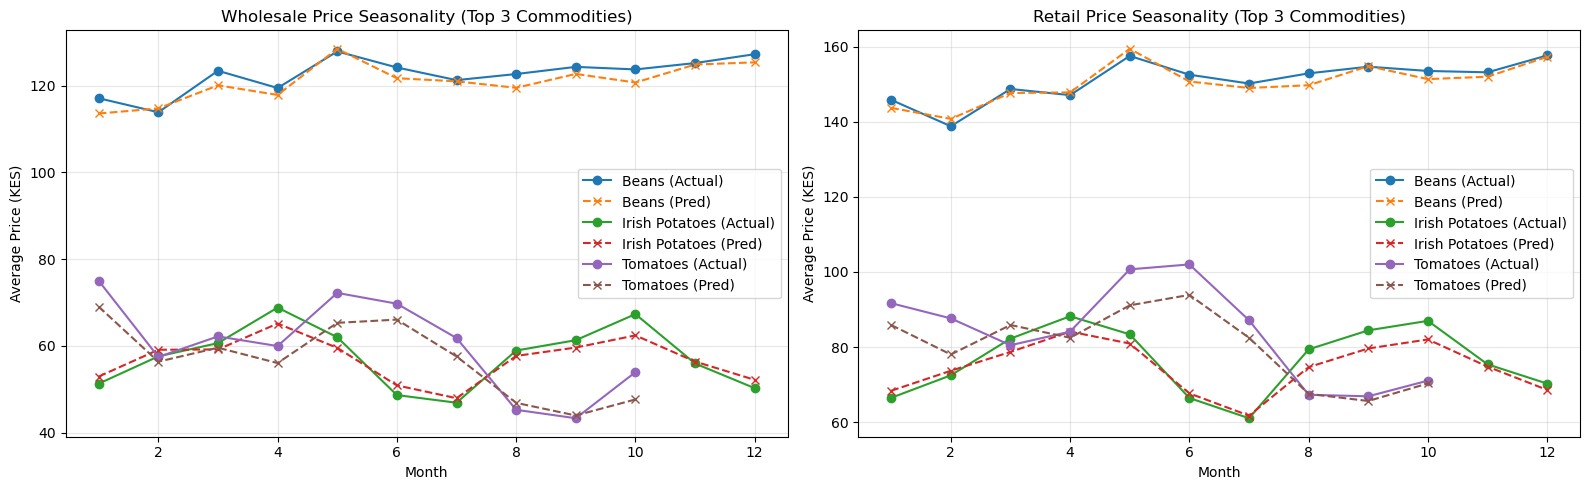

In [47]:
# Plot side-by-side for Wholesale & Retail
fig, axes = plt.subplots(1, 2, figsize=(16, 5), sharex=True)
for commodity in top_commodities:
    subset = multi_trend[multi_trend["Commodity"] == commodity]
    axes[0].plot(subset["Month"], subset["Actual_Wholesale"], marker="o", label=f"{commodity} (Actual)")
    axes[0].plot(subset["Month"], subset["Pred_Wholesale"], linestyle="--", marker="x", label=f"{commodity} (Pred)")
    axes[1].plot(subset["Month"], subset["Actual_Retail"], marker="o", label=f"{commodity} (Actual)")
    axes[1].plot(subset["Month"], subset["Pred_Retail"], linestyle="--", marker="x", label=f"{commodity} (Pred)")

axes[0].set_title("Wholesale Price Seasonality (Top 3 Commodities)")
axes[0].set_xlabel("Month")
axes[0].set_ylabel("Average Price (KES)")
axes[0].legend()
axes[0].grid(alpha=0.3)

axes[1].set_title("Retail Price Seasonality (Top 3 Commodities)")
axes[1].set_xlabel("Month")
axes[1].set_ylabel("Average Price (KES)")
axes[1].legend()
axes[1].grid(alpha=0.3)

plt.tight_layout()
plt.show()

### Price Seasonality Analysis: Top 3 Commodities
__Overview__
These charts compare actual vs predicted seasonal price patterns for beans, Irish potatoes, and tomatoes at both wholesale and retail levels throughout the year.

__Key Observations__


_Beans_

Most stable commodity with relatively consistent pricing year-round
Wholesale prices range from ~110-130 KES, retail from ~140-160 KES
Predictions closely match actual prices, indicating predictable seasonality

_Irish Potatoes_

Moderate volatility with notable seasonal fluctuations
Peak prices occur around March-April (planting season)
Lower prices during harvest periods (around August-September)
Clear seasonal pattern at both wholesale (50-70 KES) and retail (65-90 KES) levels

_Tomatoes_

Most volatile commodity with dramatic price swings
Extreme peaks during dry seasons, particularly around February and September-October
Wholesale prices can triple from ~45 KES to ~75 KES
Retail shows similar but dampened volatility (65-100 KES range)
Prediction accuracy varies, suggesting external factors influence pricing

Market Dynamics

Retail markup is consistent across all commodities (~30-40 KES above wholesale)
Seasonal patterns are more pronounced in perishable items (tomatoes) than storage crops (beans)
Predictive models work best for stable commodities but struggle with highly volatile ones

## PROPHET MODEL

## Forecasting Commodity Prices using Facebook Prophet

We apply **Facebook Prophet**, a time series forecasting tool developed by Meta, to predict future prices of agricultural commodities. Prophet is well-suited for time series with strong seasonal effects and historical data. 



In [48]:
from prophet import Prophet


In [49]:
df_p = pd.read_csv('Cleaned.csv')

### Data preparation for prophet modelling

To use Prophet, we must structure the data with two essential columns:

- `ds`: The date column.
- `y`: The value we want to forecast (in this case, price).

We filter the dataset to include only Avocado prices in Ahero Market, Kisumu, and then rename the necessary columns.


In [50]:

# Forecast Avocado wholesale price in Kisumu (Ahero Market)
df_prophet = df_p[(df_p["Commodity"] == "Avocado") & (df_p["Market"] == "Ahero") & (df_p["County"] == "Kisumu")]

# Prophet requires 'ds' (date) and 'y' (value) columns
prophet_df = df_prophet[["Date", "WholesaleUnitPrice"]].rename(columns={"Date": "ds", "WholesaleUnitPrice": "y"})


### Fit the prophet model & forecast into the future

We initialize the Prophet model with: 

- `yearly_seasonality=True`: to capture seasonal price changes such as harvest periods.
- `weekly_seasonality=True`: to capture fluctuations throughout the week.
- `daily_seasonality=False`: since our data is not intraday.

We then forecast **60 days** into the future and visualize the predicted trends and seasonality.

In [51]:

model = Prophet(
    yearly_seasonality=True,    # Captures yearly price cycles (harvest/off-season)
    weekly_seasonality=True,    # Captures weekly market trends
    daily_seasonality=False     # Daily not needed unless intraday data
)
model.fit(prophet_df)


# Forecast into the Future
future = model.make_future_dataframe(periods=60)  # Forecast 60 days ahead
forecast = model.predict(future)

16:02:06 - cmdstanpy - INFO - Chain [1] start processing
16:02:09 - cmdstanpy - INFO - Chain [1] done processing


### Visualizing the Forecast

The following plots are generated:

1. **Forecast Plot** – shows actual data and future predictions with confidence intervals.
2. **Components Plot** – decomposes the forecast into trend and seasonal components, helping us understand cyclical behaviors in the price data.


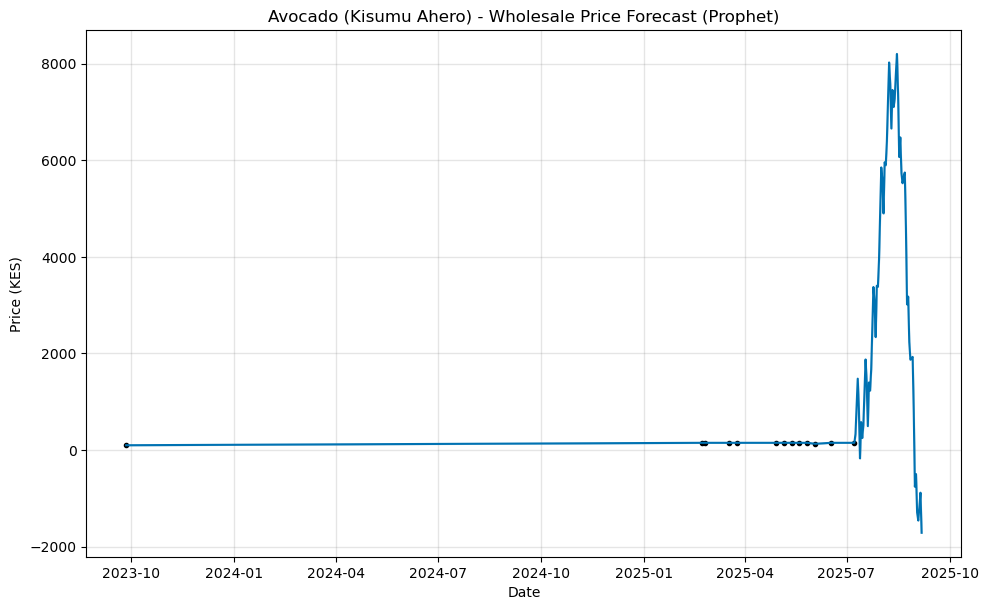

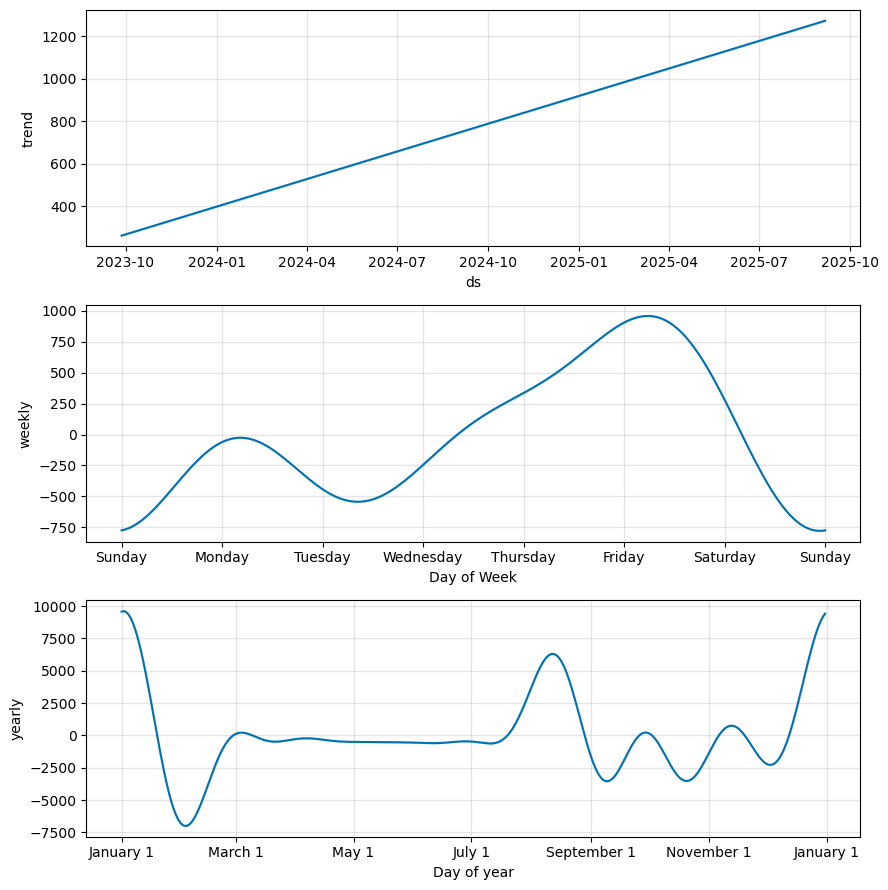

In [52]:
# Plot Forecast
fig1 = model.plot(forecast)
plt.title("Avocado (Kisumu Ahero) - Wholesale Price Forecast (Prophet)")
plt.xlabel("Date")
plt.ylabel("Price (KES)")
plt.show()

# Plotting forecast components (trend + seasonality breakdown)
fig2 = model.plot_components(forecast)
plt.show()

### Batch Prophet Forecasting Pipeline


To scale forecasting, we implement a pipeline that loops through each unique combination of:

- `Commodity`
- `Market`
- `County`

For each group, we:
- Prepare separate data for **wholesale** and **retail** prices.
- Fit a Prophet model for each.
- Forecast prices for the next **60 days**.
- Append the forecast results, including confidence intervals.

Finally, we consolidate all results into a single DataFrame and export it to a CSV file for further use.


In [53]:
# How many days into the future to forecast
FORECAST_HORIZON = 60

# Container for all forecasts
all_forecasts = []

# Group by Commodity + Market + County
for (commodity, market, county), group in df.groupby(["Commodity", "Market", "County"]):
    group = group.sort_values("Date")

    # Skipping groups with very few data points (Prophet needs some history)
    if len(group) < 20:
        continue

    # Preparing data for Prophet (Wholesale)
    df_wholesale = group[["Date", "WholesaleUnitPrice"]].rename(columns={"Date": "ds", "WholesaleUnitPrice": "y"})
    model_wholesale = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    model_wholesale.fit(df_wholesale)
    future_wholesale = model_wholesale.make_future_dataframe(periods=FORECAST_HORIZON)
    forecast_wholesale = model_wholesale.predict(future_wholesale)
    forecast_wholesale["Commodity"] = commodity
    forecast_wholesale["Market"] = market
    forecast_wholesale["County"] = county
    forecast_wholesale["Price_Type"] = "Wholesale"
    all_forecasts.append(forecast_wholesale[["ds", "yhat", "yhat_lower", "yhat_upper", "Commodity", "Market", "County", "Price_Type"]])

    # Preparing data for Prophet (Retail)
    df_retail = group[["Date", "RetailUnitPrice"]].rename(columns={"Date": "ds", "RetailUnitPrice": "y"})
    model_retail = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
    model_retail.fit(df_retail)
    future_retail = model_retail.make_future_dataframe(periods=FORECAST_HORIZON)
    forecast_retail = model_retail.predict(future_retail)
    forecast_retail["Commodity"] = commodity
    forecast_retail["Market"] = market
    forecast_retail["County"] = county
    forecast_retail["Price_Type"] = "Retail"
    all_forecasts.append(forecast_retail[["ds", "yhat", "yhat_lower", "yhat_upper", "Commodity", "Market", "County", "Price_Type"]])

# Combining all forecasts into one DataFrame
final_forecasts = pd.concat(all_forecasts, ignore_index=True)

# Save to CSV for later use
final_forecasts.to_csv("commodity_price_forecasts.csv", index=False)

print("Batch forecasting complete! Saved to 'commodity_price_forecasts.csv'.")
print(final_forecasts.head())


16:02:12 - cmdstanpy - INFO - Chain [1] start processing
16:02:12 - cmdstanpy - INFO - Chain [1] done processing
16:02:13 - cmdstanpy - INFO - Chain [1] start processing
16:02:13 - cmdstanpy - INFO - Chain [1] done processing
16:02:13 - cmdstanpy - INFO - Chain [1] start processing
16:02:14 - cmdstanpy - INFO - Chain [1] done processing
16:02:15 - cmdstanpy - INFO - Chain [1] start processing
16:02:15 - cmdstanpy - INFO - Chain [1] done processing
16:02:16 - cmdstanpy - INFO - Chain [1] start processing
16:02:17 - cmdstanpy - INFO - Chain [1] done processing
16:02:17 - cmdstanpy - INFO - Chain [1] start processing
16:02:18 - cmdstanpy - INFO - Chain [1] done processing
16:02:18 - cmdstanpy - INFO - Chain [1] start processing
16:02:18 - cmdstanpy - INFO - Chain [1] done processing
16:02:19 - cmdstanpy - INFO - Chain [1] start processing
16:02:20 - cmdstanpy - INFO - Chain [1] done processing
16:02:21 - cmdstanpy - INFO - Chain [1] start processing
16:02:21 - cmdstanpy - INFO - Chain [1]

Batch forecasting complete! Saved to 'commodity_price_forecasts.csv'.
          ds       yhat  yhat_lower  yhat_upper Commodity Market County  \
0 2023-08-23  19.222695   16.101133   22.435184   Avocado  Akala  Siaya   
1 2024-06-05   8.203320    5.317814   11.357559   Avocado  Akala  Siaya   
2 2024-06-08  13.869226   10.816207   16.954569   Avocado  Akala  Siaya   
3 2024-06-13  15.643993   12.352401   18.636792   Avocado  Akala  Siaya   
4 2024-06-26  11.464681    8.385971   14.938271   Avocado  Akala  Siaya   

  Price_Type  
0  Wholesale  
1  Wholesale  
2  Wholesale  
3  Wholesale  
4  Wholesale  


What this does:
1. Iterates over every commodity-market-county combination.

2. Fits two Prophet models (Wholesale and Retail) for each series.

3. Forecasts 60 days ahead with uncertainty intervals (yhat_lower, yhat_upper).

4. Stores all results into a single CSV.

In [54]:

# Selecting top 5 commodities by record count (to avoid sparse series)
top_commodities = df_p["Commodity"].value_counts().head(5).index

results = []

for commodity in top_commodities:
    for price_col, price_type in [("WholesaleUnitPrice", "Wholesale"), ("RetailUnitPrice", "Retail")]:
        
        # Filterint the series for this commodity (all markets/counties combined)
        df_series = df_p[df_p["Commodity"] == commodity][["Date", price_col]].rename(
            columns={"Date": "ds", price_col: "y"}
        ).dropna().sort_values("ds")
        
        # we will us this to skip if not enough history
        if len(df_series) < 90:  # ~3 months of data minimum
            continue
        
        # Train/test split (last 60 days for testing)
        train = df_series.iloc[:-60]
        test = df_series.iloc[-60:]
        
        # Fit Prophet
        model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
        model.fit(train)
        
        # Forecast for the test period
        future = model.make_future_dataframe(periods=60, freq='D')
        forecast = model.predict(future)
        
        # Align datetime columns
        forecast["ds"] = pd.to_datetime(forecast["ds"])
        test["ds"] = pd.to_datetime(test["ds"])
        
        # Align predictions to test dates
        pred_test = forecast.set_index("ds").reindex(test["ds"])["yhat"]
        
        # Reset index to avoid Timestamp vs Int alignment issues
        pred_test = pred_test.reset_index(drop=True)
        actual_test = test["y"].reset_index(drop=True)
        
        # Drop any rows with missing predictions or actuals
        mask = (~pred_test.isna()) & (~actual_test.isna())
        pred_test = pred_test[mask]
        actual_test = actual_test[mask]
        
        # Compute accuracy metrics
        mae = mean_absolute_error(actual_test, pred_test)
        rmse = mean_squared_error(actual_test, pred_test, squared=False)
        mape = np.mean(np.abs((actual_test - pred_test) / actual_test)) * 100
        
        results.append({
            "Commodity": commodity,
            "Price_Type": price_type,
            "MAE": mae,
            "RMSE": rmse,
            "MAPE (%)": mape
        })

# Convert results to DataFrame and sort by best (lowest) MAPE
accuracy_df = pd.DataFrame(results).sort_values(by="MAPE (%)")
print(accuracy_df)


16:14:44 - cmdstanpy - INFO - Chain [1] start processing
16:14:50 - cmdstanpy - INFO - Chain [1] done processing
16:14:53 - cmdstanpy - INFO - Chain [1] start processing
16:14:59 - cmdstanpy - INFO - Chain [1] done processing
16:15:00 - cmdstanpy - INFO - Chain [1] start processing
16:15:01 - cmdstanpy - INFO - Chain [1] done processing
16:15:03 - cmdstanpy - INFO - Chain [1] start processing
16:15:04 - cmdstanpy - INFO - Chain [1] done processing
16:15:04 - cmdstanpy - INFO - Chain [1] start processing
16:15:05 - cmdstanpy - INFO - Chain [1] done processing
16:15:05 - cmdstanpy - INFO - Chain [1] start processing
16:15:05 - cmdstanpy - INFO - Chain [1] done processing
16:15:06 - cmdstanpy - INFO - Chain [1] start processing
16:15:06 - cmdstanpy - INFO - Chain [1] done processing
16:15:07 - cmdstanpy - INFO - Chain [1] start processing
16:15:07 - cmdstanpy - INFO - Chain [1] done processing
16:15:08 - cmdstanpy - INFO - Chain [1] start processing
16:15:08 - cmdstanpy - INFO - Chain [1]

        Commodity Price_Type        MAE       RMSE    MAPE (%)
4     Wheat Flour  Wholesale   7.615836  13.550964    8.916713
5     Wheat Flour     Retail   9.170609  16.223309    8.975597
1           Beans     Retail  27.417594  32.518259   19.374334
0           Beans  Wholesale  22.758837  26.764619   19.927779
3  Irish Potatoes     Retail  16.977539  21.333531   32.075046
2  Irish Potatoes  Wholesale  11.671506  14.795235   42.368362
8         Avocado  Wholesale  37.159448  40.864529  133.805295
6            Eggs  Wholesale   3.131544   4.551923  174.483493
9         Avocado     Retail  41.355144  46.563317  178.432141
7            Eggs     Retail   4.012319   5.547659  190.376562


What this does
 1. Loops through the top 5 commodities (by number of rows).

 2. Evaluates Prophet for Wholesale and Retail prices separately.

 3. Uses the last 60 days as the test period.

 4. Outputs a summary table with MAE, RMSE, and MAPE (sorted by best performance)

16:15:09 - cmdstanpy - INFO - Chain [1] start processing
16:15:10 - cmdstanpy - INFO - Chain [1] done processing


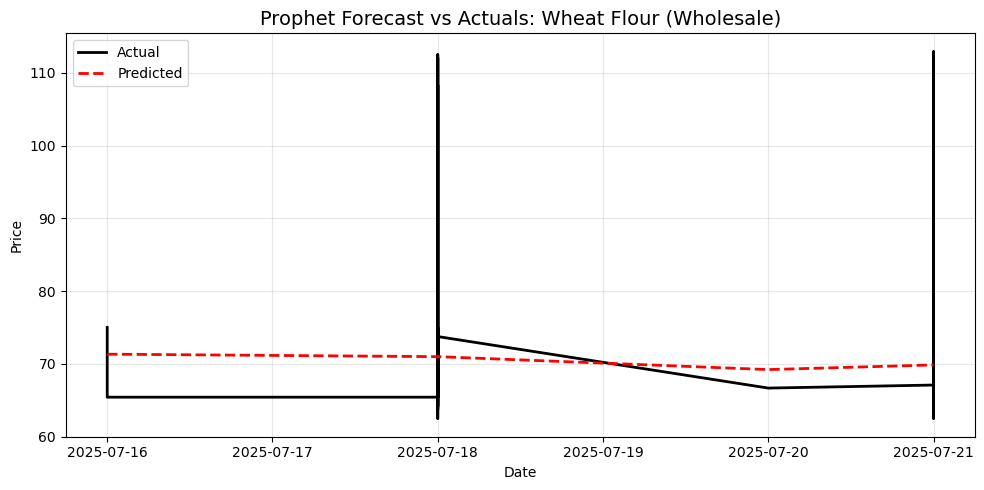

16:15:10 - cmdstanpy - INFO - Chain [1] start processing
16:15:11 - cmdstanpy - INFO - Chain [1] done processing


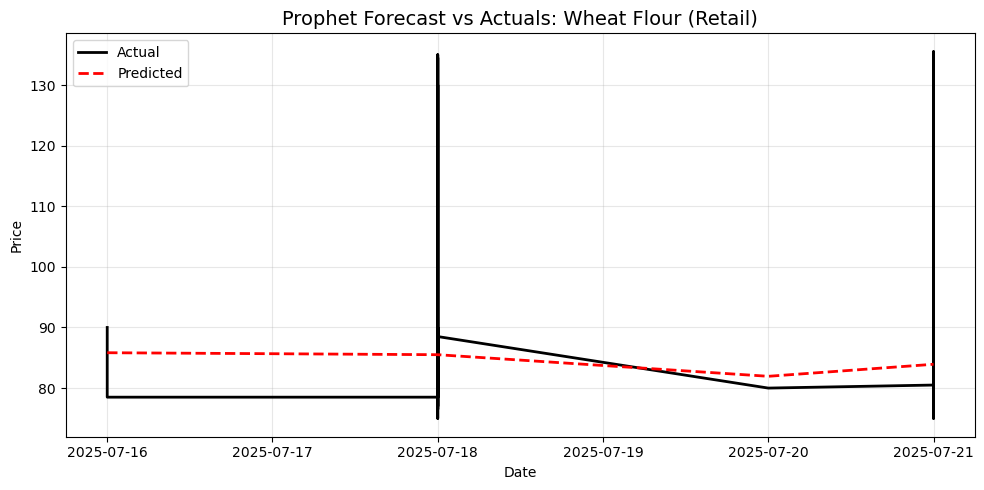

16:15:13 - cmdstanpy - INFO - Chain [1] start processing
16:15:19 - cmdstanpy - INFO - Chain [1] done processing


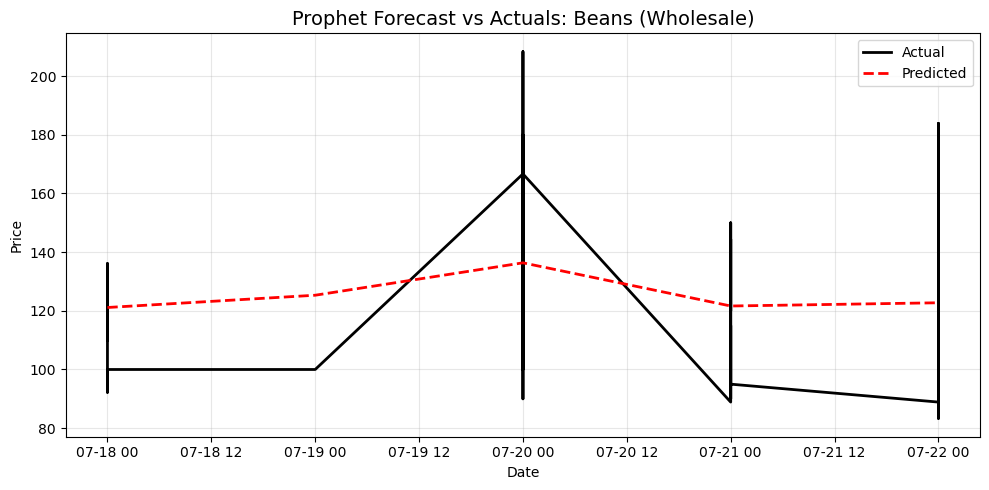

16:15:22 - cmdstanpy - INFO - Chain [1] start processing
16:15:27 - cmdstanpy - INFO - Chain [1] done processing


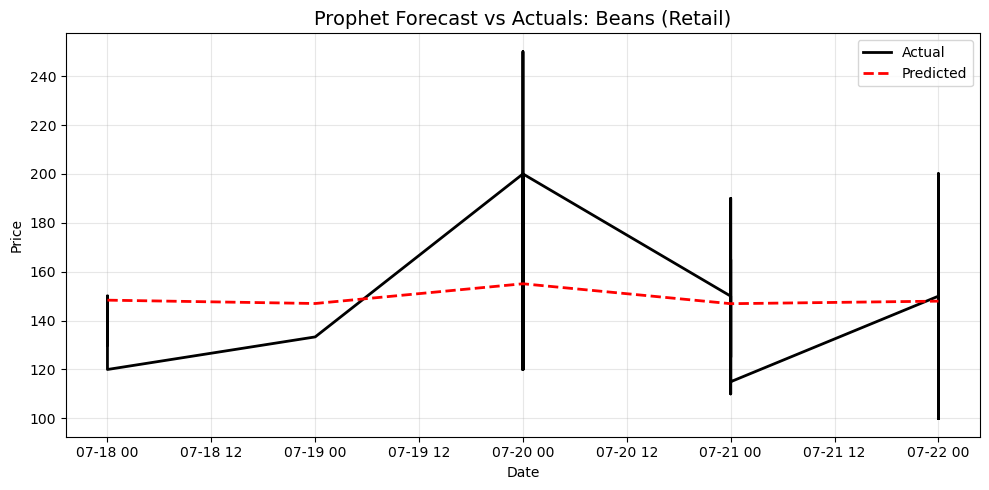

16:15:28 - cmdstanpy - INFO - Chain [1] start processing
16:15:30 - cmdstanpy - INFO - Chain [1] done processing


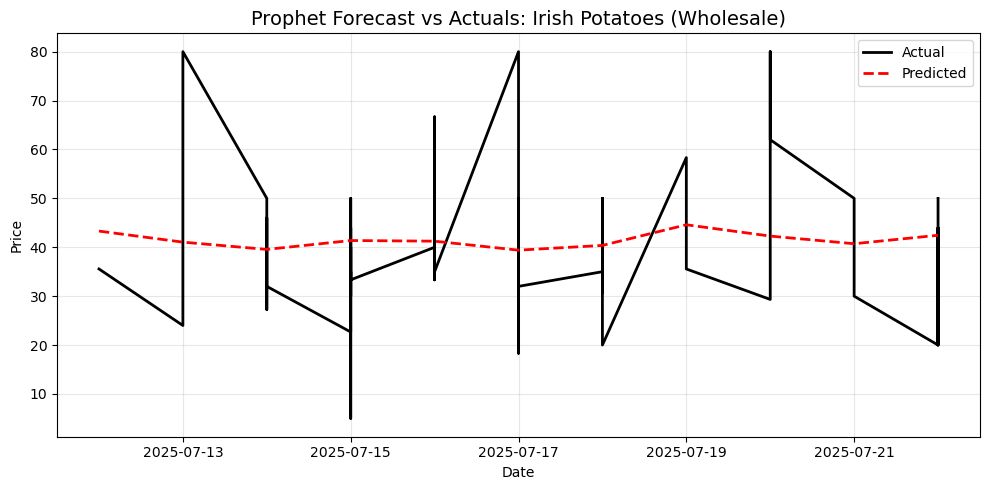

16:15:31 - cmdstanpy - INFO - Chain [1] start processing
16:15:33 - cmdstanpy - INFO - Chain [1] done processing


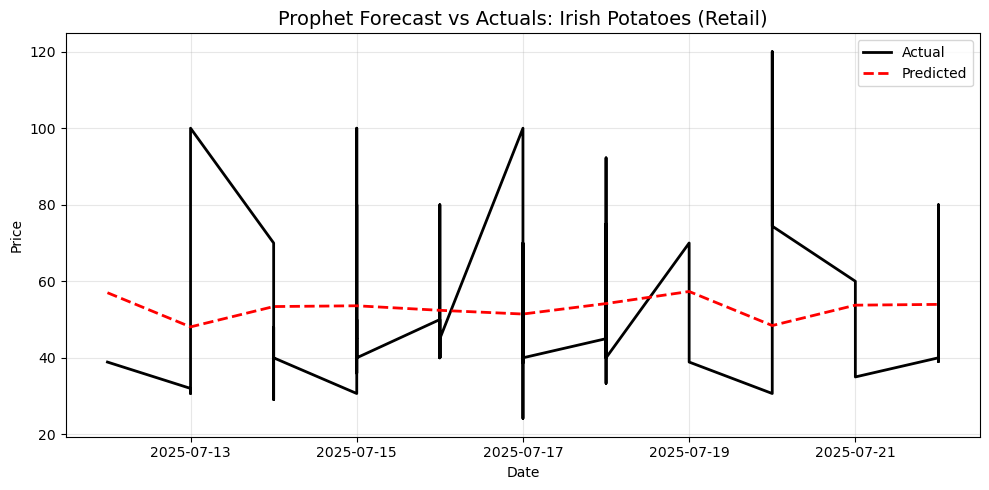

16:15:34 - cmdstanpy - INFO - Chain [1] start processing
16:15:34 - cmdstanpy - INFO - Chain [1] done processing


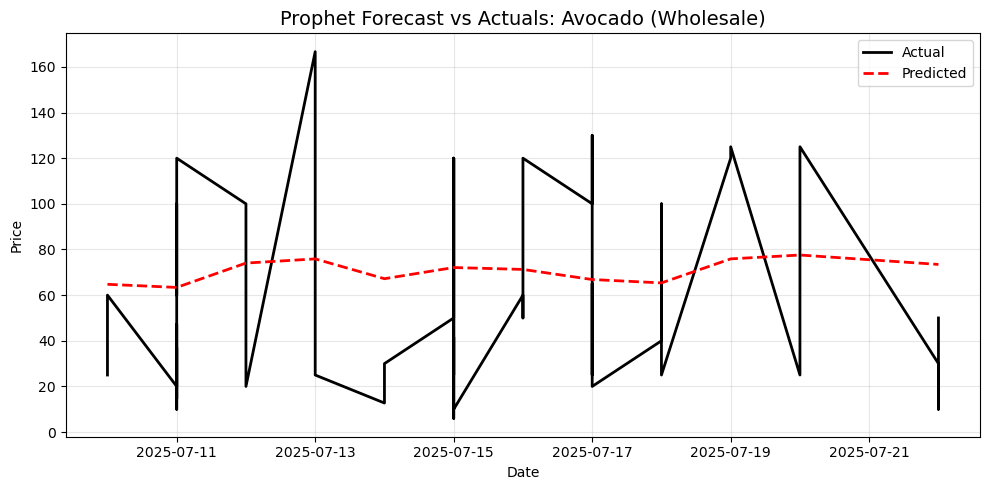

16:15:35 - cmdstanpy - INFO - Chain [1] start processing
16:15:35 - cmdstanpy - INFO - Chain [1] done processing


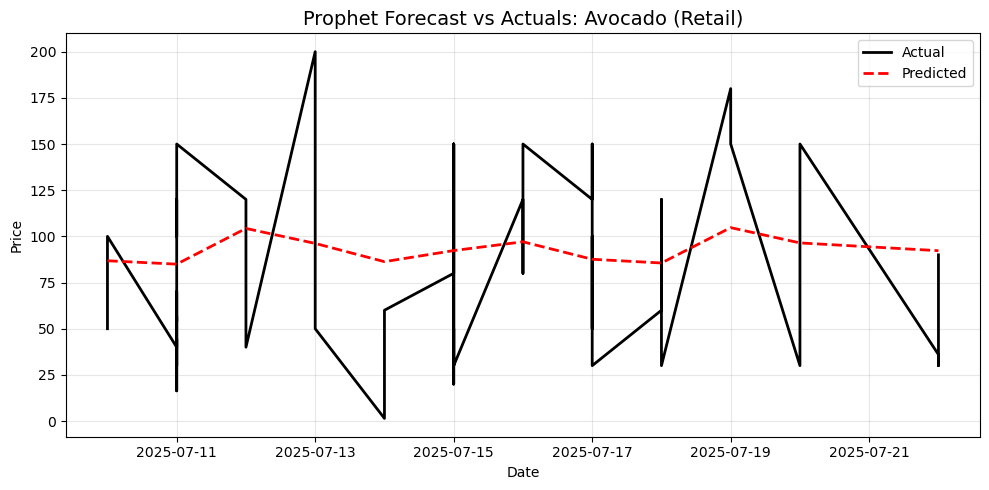

16:15:36 - cmdstanpy - INFO - Chain [1] start processing
16:15:36 - cmdstanpy - INFO - Chain [1] done processing


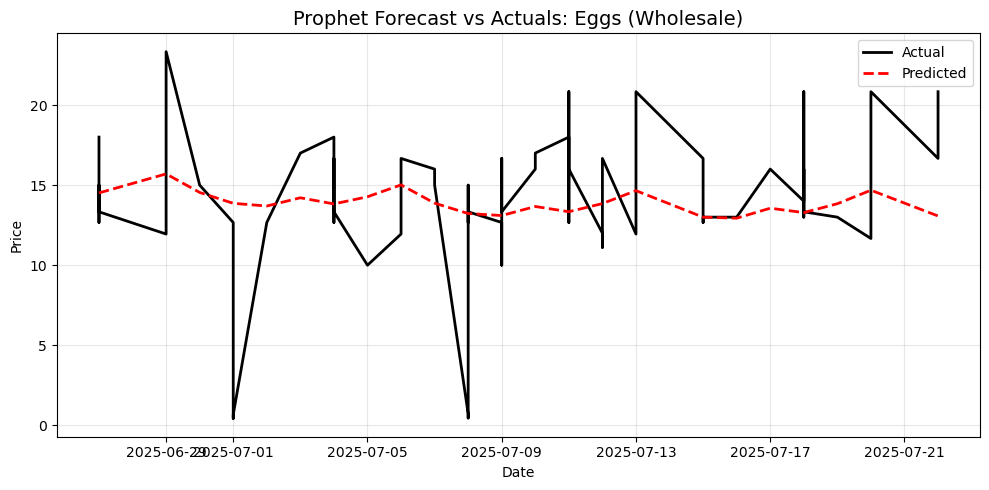

16:15:37 - cmdstanpy - INFO - Chain [1] start processing
16:15:38 - cmdstanpy - INFO - Chain [1] done processing


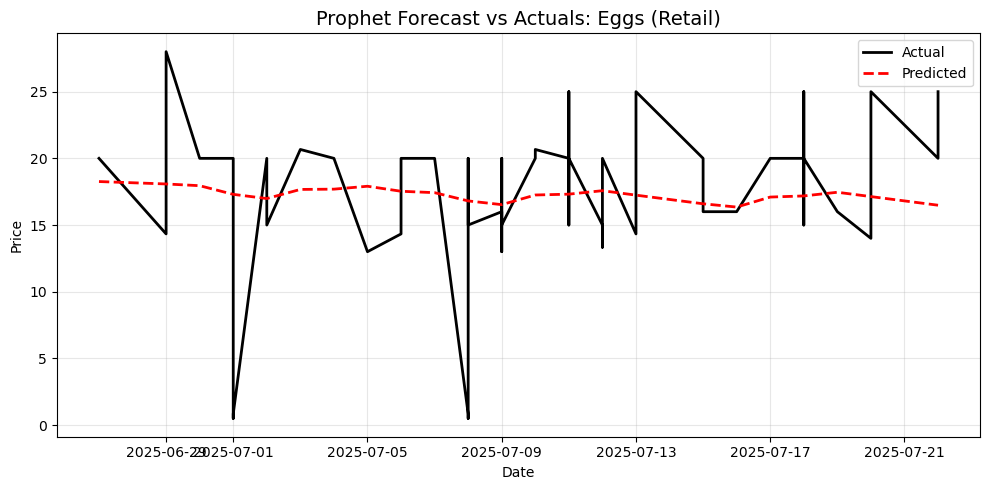

In [55]:
# Visualize Prophet predictions vs actuals for the top 5 commodities
for commodity in accuracy_df["Commodity"].unique():
    for price_col, price_type in [("WholesaleUnitPrice", "Wholesale"), ("RetailUnitPrice", "Retail")]:
        
        # Prepare series
        df_series = df_p[df_p["Commodity"] == commodity][["Date", price_col]].rename(
            columns={"Date": "ds", price_col: "y"}
        ).dropna().sort_values("ds")
        
        if len(df_series) < 90:
            continue
        
        # Train/test split (last 60 days as test)
        train = df_series.iloc[:-60]
        test = df_series.iloc[-60:]
        
        # Fit Prophet and forecast
        model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
        model.fit(train)
        future = model.make_future_dataframe(periods=60, freq='D')
        forecast = model.predict(future)
        
        # Align dates
        forecast["ds"] = pd.to_datetime(forecast["ds"])
        test["ds"] = pd.to_datetime(test["ds"])
        
        # Align predictions with test dates
        pred_test = forecast.set_index("ds").reindex(test["ds"])["yhat"].reset_index(drop=True)
        actual_test = test["y"].reset_index(drop=True)
        
        # Plot
        plt.figure(figsize=(10, 5))
        plt.plot(test["ds"], actual_test, label="Actual", color="black", linewidth=2)
        plt.plot(test["ds"], pred_test, label="Predicted", color="red", linestyle="--", linewidth=2)
        
        plt.title(f"Prophet Forecast vs Actuals: {commodity} ({price_type})", fontsize=14)
        plt.xlabel("Date")
        plt.ylabel("Price")
        plt.legend()
        plt.grid(alpha=0.3)
        plt.tight_layout()
        plt.show()


### Top 5 commodities by record count


In [56]:
top_commodities = df_p["Commodity"].value_counts().head(5).index

results = []

for commodity in top_commodities:
    for price_col, price_type in [("WholesaleUnitPrice", "Wholesale"), ("RetailUnitPrice", "Retail")]:
        
        # Prepare series
        df_series = df_p[df_p["Commodity"] == commodity][["Date", price_col]].rename(
            columns={"Date": "ds", price_col: "y"}
        ).dropna().sort_values("ds")
        
        # Skipping the  short series
        if len(df_series) < 90:
            continue
        
        # Train/test split (last 60 days as test)
        train = df_series.iloc[:-60]
        test = df_series.iloc[-60:]
        
        # Fit Prophet
        model = Prophet(yearly_seasonality=True, weekly_seasonality=True, daily_seasonality=False)
        model.fit(train)
        future = model.make_future_dataframe(periods=60, freq='D')
        forecast = model.predict(future)
        
        # Align predictions
        forecast["ds"] = pd.to_datetime(forecast["ds"])
        test["ds"] = pd.to_datetime(test["ds"])
        pred_test = forecast.set_index("ds").reindex(test["ds"])["yhat"].reset_index(drop=True)
        actual_test = test["y"].reset_index(drop=True)
        
        # Clean NaNs
        mask = (~pred_test.isna()) & (~actual_test.isna())
        pred_test = pred_test[mask]
        actual_test = actual_test[mask]
        
        # Metrics
        mae = mean_absolute_error(actual_test, pred_test)
        rmse = mean_squared_error(actual_test, pred_test, squared=False)
        mape = np.mean(np.abs((actual_test - pred_test) / actual_test)) * 100
        r2 = r2_score(actual_test, pred_test)
        
        results.append({
            "Commodity": commodity,
            "Price_Type": price_type,
            "MAE": mae,
            "RMSE": rmse,
            "MAPE (%)": mape,
            "R²": r2
        })

# Results sorted by R² (best performing first)
accuracy_df = pd.DataFrame(results).sort_values(by="R²", ascending=False)
print(accuracy_df)


16:15:40 - cmdstanpy - INFO - Chain [1] start processing
16:15:46 - cmdstanpy - INFO - Chain [1] done processing
16:15:48 - cmdstanpy - INFO - Chain [1] start processing
16:15:54 - cmdstanpy - INFO - Chain [1] done processing
16:15:55 - cmdstanpy - INFO - Chain [1] start processing
16:15:56 - cmdstanpy - INFO - Chain [1] done processing
16:15:57 - cmdstanpy - INFO - Chain [1] start processing
16:15:58 - cmdstanpy - INFO - Chain [1] done processing
16:15:59 - cmdstanpy - INFO - Chain [1] start processing
16:15:59 - cmdstanpy - INFO - Chain [1] done processing
16:16:00 - cmdstanpy - INFO - Chain [1] start processing
16:16:00 - cmdstanpy - INFO - Chain [1] done processing
16:16:01 - cmdstanpy - INFO - Chain [1] start processing
16:16:01 - cmdstanpy - INFO - Chain [1] done processing
16:16:02 - cmdstanpy - INFO - Chain [1] start processing
16:16:02 - cmdstanpy - INFO - Chain [1] done processing
16:16:02 - cmdstanpy - INFO - Chain [1] start processing
16:16:03 - cmdstanpy - INFO - Chain [1]

        Commodity Price_Type        MAE       RMSE    MAPE (%)        R²
0           Beans  Wholesale  22.758837  26.764619   19.927779  0.086542
9         Avocado     Retail  41.355144  46.563317  178.432141  0.034457
1           Beans     Retail  27.417594  32.518259   19.374334  0.033682
7            Eggs     Retail   4.012319   5.547659  190.376562  0.017065
6            Eggs  Wholesale   3.131544   4.551923  174.483493  0.014832
2  Irish Potatoes  Wholesale  11.671506  14.795235   42.368362 -0.006661
8         Avocado  Wholesale  37.159448  40.864529  133.805295 -0.009797
5     Wheat Flour     Retail   9.170609  16.223309    8.975597 -0.032441
4     Wheat Flour  Wholesale   7.615836  13.550964    8.916713 -0.037264
3  Irish Potatoes     Retail  16.977539  21.333531   32.075046 -0.065596


### Prophet Model Evaluation Metrics

The following table summarizes the performance of the Prophet model across different commodities and price types (Wholesale vs Retail). The metrics reported include:

- **MAE** (Mean Absolute Error)
- **RMSE** (Root Mean Squared Error)
- **MAPE** (Mean Absolute Percentage Error)
- **R²** (Coefficient of Determination)

| Commodity        | Price Type | MAE        | RMSE       | MAPE (%)   | R²        |
|------------------|------------|------------|------------|------------|-----------|
| Beans            | Wholesale  | 22.76      | 26.76      | 19.93      | 0.087     |
| Beans            | Retail     | 27.42      | 32.52      | 19.37      | 0.034     |
| Irish Potatoes   | Wholesale  | 11.67      | 14.80      | 42.37      | -0.007    |
| Irish Potatoes   | Retail     | 16.98      | 21.33      | 32.08      | -0.066    |
| Wheat Flour      | Wholesale  | 7.62       | 13.55      | 8.92       | -0.037    |
| Wheat Flour      | Retail     | 9.17       | 16.22      | 8.98       | -0.032    |
| Eggs             | Wholesale  | 3.13       | 4.55       | 174.48     | 0.015     |
| Eggs             | Retail     | 4.01       | 5.55       | 190.38     | 0.017     |
| Avocado          | Wholesale  | 37.16      | 40.86      | 133.81     | -0.010    |
| Avocado          | Retail     | 41.36      | 46.56      | 178.43     | 0.034     |

**Note:**  
- Lower MAE and RMSE values indicate better predictive accuracy.  
- MAPE values above 100% suggest large percentage errors relative to actual values.  
- A negative R² implies that the model performs worse than a horizontal line (mean prediction).

Given the **overall poor performance**, especially in cases with high MAPE and negative R², we opted to explore more advanced models such as **LSTM** for improved forecasting accuracy.

# LSTM

1. Why LSTM could work here
- LSTMs are neural networks designed for time-series, capable of remembering past states (lags) automatically.

- Can capture nonlinear patterns, spikes, and delayed effects better than Prophet.

- Handles multi-step forecasting by learning sequential dependencies.

2. Basic Setup
We’ll:

1. Use one commodity at a time (e.g., Beans Wholesale first).

2. Scale prices (LSTMs are sensitive to scale).

3. Create sequences (lags):

 - Input: last n days (e.g., 30)

 - Output: next day’s price.

4. Train an LSTM model using Keras/TensorFlow.

5. Evaluate on last 60 days using RMSE, MAE, MAPE, R².

In [57]:
# we select single series (Beans Wholesale)
commodity = "Beans"
price_col = "WholesaleUnitPrice"
df_series = df_p[df_p["Commodity"] == commodity][["Date", price_col]].dropna().sort_values("Date")

# Scale prices (LSTM needs scaled inputs)
scaler = MinMaxScaler()
prices_scaled = scaler.fit_transform(df_series[[price_col]])


In [58]:
# Create sequences (e.g. 30 days input → 1 day output)
def create_sequences(data, window=30):
    X, y = [], []
    for i in range(window, len(data)):
        X.append(data[i-window:i, 0])
        y.append(data[i, 0])
    return np.array(X), np.array(y)

window_size = 30
X, y = create_sequences(prices_scaled, window_size)



### Split Data and Reshape for LSTM

We split the sequences:

- **Training set**: All data except the last 60 days
- **Test set**: Last 60 days (to evaluate performance)

LSTM expects input in the shape:  
`(samples, time_steps, features)` → So we reshape the input accordingly.


In [59]:
# Split train/test (last 60 days as test)
split = len(X) - 60
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Reshape for LSTM (samples, timesteps, features)
X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], 1))
X_test = X_test.reshape((X_test.shape[0], X_test.shape[1], 1))

### Build and Train the LSTM model


We use the following LSTM architecture: 

- `LSTM (64 units)` – learns temporal patterns  
- `Dropout (20%)` – prevents overfitting  
- `Dense (1)` – outputs the next day's price

The model is compiled with:

- **Loss**: Mean Squared Error (MSE)  
- **Optimizer**: Adam  

Training is done over 30 epochs with a batch size of 16.

In [60]:
model = Sequential()
model.add(LSTM(64, return_sequences=False, input_shape=(window_size, 1)))
model.add(Dropout(0.2))
model.add(Dense(1))  # Predict next price

model.compile(optimizer='adam', loss='mse')
model.fit(X_train, y_train, epochs=30, batch_size=16, verbose=1)


c:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/30
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 19s 11ms/step - loss: 0.0307
Epoch 2/30
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0219
Epoch 3/30
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 21s 11ms/step - loss: 0.0217
Epoch 4/30
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - loss: 0.0214
Epoch 5/30
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.0200
Epoch 6/30
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.0202
Epoch 7/30
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.0202
Epoch 8/30
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.0207
Epoch 9/30
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.0209
Epoch 10/30
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.0204
Epoch 11/30
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.0204
Epoch 12/30
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.0200
Epoch 13/30
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 12s 11ms/step - loss: 0.0200
Epoch 14/30
1076/1076 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - loss: 0.0200
E

### Prediction and evaluation of the model performance

After training, we:

1. **Predict** the next 60 days of prices using the test set.
2. **Inverse scale** the predictions to get real KES values.
3. **Evaluate** the model using:

- **MAE**: Mean Absolute Error  
- **RMSE**: Root Mean Squared Error  
- **MAPE**: Mean Absolute Percentage Error  
- **R²**: Coefficient of Determination

These metrics help us compare LSTM performance against the others

In [61]:
# Predict
pred_scaled = model.predict(X_test)
pred_prices = scaler.inverse_transform(pred_scaled.reshape(-1, 1))
actual_prices = scaler.inverse_transform(y_test.reshape(-1, 1))

# Evaluate
mae = mean_absolute_error(actual_prices, pred_prices)
rmse = mean_squared_error(actual_prices, pred_prices, squared=False)
r2 = r2_score(actual_prices, pred_prices)
mape = np.mean(np.abs((actual_prices - pred_prices) / actual_prices)) * 100

print(f"LSTM Results for {commodity} ({price_col}):")
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")


2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 316ms/step
LSTM Results for Beans (WholesaleUnitPrice):
MAE: 23.20, RMSE: 27.96, R²: 0.0028, MAPE: 19.45%


### LSTM Results for Beans (Wholesale) 

After training and evaluating the LSTM model on Beans Wholesale prices, we obtained the following performance metrics: 

- **MAE**: 23.20  
- **RMSE**: 27.96  
- **MAPE**: 19.45%  
- **R² Score**: 0.0028

**Interpretation**: 

- The R² value is close to zero, meaning the model explains very little variance in the data.
- However, the **MAPE** is under 20%, which shows reasonable predictive accuracy in percentage terms.
- This suggests the model performs decently in terms of *directional forecasting*, though variance explanation i limited.s limited.

### HYPERTUNE THE MODEL DUE TO THE POOR PERFORMANCE

In [62]:
### Data Preparation and rollng of features

### Filter and Prepare the Beans (Wholesale) Time Series 

We start by selecting the "Beans" series for the "WholesaleUnitPrice" column and sort it by date. To help the model capture recent trends and volatility, we create rolling features:
- 7-day **rolling mean**
- 7-day **rolling standard deviation**

We drop the first 7 rows since rolling statistics require a window to compute.


In [63]:
commodity = "Beans"
price_col = "WholesaleUnitPrice"

df_series = df_p[df_p["Commodity"] == commodity][["Date", price_col]].dropna().sort_values("Date")
df_series.set_index("Date", inplace=True)

# Add rolling features
df_series["rolling_mean_7"] = df_series[price_col].rolling(7).mean()
df_series["rolling_std_7"] = df_series[price_col].rolling(7).std()
df_series = df_series.dropna()  # Drop first 7 rows


### Scale the Time Series Features 

To prepare the data for the LSTM model, we apply **MinMax Scaling** to normalize all columns between 0 and 1. This is important for deep learning models as it speeds up convergence and improves accuracy

In [64]:
#Scale features
scaler = MinMaxScaler()
scaled = scaler.fit_transform(df_series)

# Convert back to DataFrame
scaled_df = pd.DataFrame(scaled, index=df_series.index, columns=df_series.columns)


### Creation of sequence (30 days input -> 7 days forecast)


##### Create Sliding Windows of Input Sequences 

We define a function to create supervised learning sequences using:
- `window = 30`: Lookback window of 30 days
- `horizon = 7`: Predict the next 7 days

Each sample becomes a 3D array: `(samples, window, features)`

In [65]:
def create_sequences_multi(data, window=30, horizon=7):
    X, y = [], []
    for i in range(window, len(data) - horizon):
        X.append(data[i-window:i])
        y.append(data[i:i+horizon, 0])  # First column is price
    return np.array(X), np.array(y)

window_size = 30
horizon = 7
X, y = create_sequences_multi(scaled_df.values, window_size, horizon)


### Split into Train and Test Sets 

We split the data chronologically, leaving the last 60 samples for testing. This preserves temporal order and mimics real-world forecasting where future data is unseen.

In [66]:
split = len(X) - 60
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


### Build and Train a Tuned LSTM Model 

We use a deeper LSTM model architecture:
- First LSTM layer with 128 units and `return_sequences=True`
- Dropout for regularization
- Second LSTM layer with 64 units
- Final Dense layer outputs the 7-day forecast

We train using the **Adam optimizer**, **MSE loss**, and implement **early stopping** to avoid overftting.


In [67]:
model = Sequential()
model.add(LSTM(128, return_sequences=True, input_shape=(window_size, X.shape[2])))
model.add(Dropout(0.2))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.2))
model.add(Dense(horizon))  # Predict next 7 prices

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=16, validation_split=0.2,
          callbacks=[early_stop], verbose=1)

c:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\rnn\rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 35s 33ms/step - loss: 0.0357 - val_loss: 0.0222
Epoch 2/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - loss: 0.0221 - val_loss: 0.0226
Epoch 3/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 27s 32ms/step - loss: 0.0213 - val_loss: 0.0218
Epoch 4/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 26s 31ms/step - loss: 0.0211 - val_loss: 0.0226
Epoch 5/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - loss: 0.0207 - val_loss: 0.0221
Epoch 6/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 27s 31ms/step - loss: 0.0208 - val_loss: 0.0218
Epoch 7/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - loss: 0.0205 - val_loss: 0.0219
Epoch 8/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - loss: 0.0201 - val_loss: 0.0218
Epoch 9/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - loss: 0.0202 - val_loss: 0.0221
Epoch 10/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 40s 28ms/step - loss: 0.0201 - val_loss: 0.0218
Epoch 11/50
860/860 ━━━━━━━━━━━━━━━━━━━━ 25s 29ms/step - loss: 0.0202 - val_loss: 0.0222


### Make Predictions on Test Set 

After training, we generate scaled predictions for the test set using the trained model


In [68]:
pred_scaled = model.predict(X_test)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 468ms/step


### Convert Predictions Back to Original Scale 

We inverse transform the scaled predictions and ground truth to obtain interpretable price values. Only the **last day** of each 7-day forecast horizon is compared to actuals

In [69]:
# Inverse transform predictions and actuals (only price column)
pred_full = np.zeros((pred_scaled.shape[0], scaled_df.shape[1]))
actual_full = np.zeros_like(pred_full)

pred_full[:, 0] = pred_scaled[:, -1]  # Compare last predicted day
actual_full[:, 0] = y_test[:, -1]     # Compare last actual day

pred_prices = scaler.inverse_transform(pred_full)[:, 0]
actual_prices = scaler.inverse_transform(actual_full)[:, 0]


### Evaluate the Tuned LSTM Model 

We compute the following evaluation metrics:
- **MAE**: Mean Absolute Error
- **RMSE**: Root Mean Squared Error
- **R² Score**: Goodness of fit (can be negative if poor)
- **MAPE**: Mean Absolute Percentage Error



In [70]:
mae = mean_absolute_error(actual_prices, pred_prices)
rmse = mean_squared_error(actual_prices, pred_prices, squared=False)
r2 = r2_score(actual_prices, pred_prices)
mape = np.mean(np.abs((actual_prices - pred_prices) / actual_prices)) * 100

print(f"Tuned LSTM Results for {commodity} ({price_col}):")
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")


Tuned LSTM Results for Beans (WholesaleUnitPrice):
MAE: 23.73, RMSE: 28.18, R²: -0.0062, MAPE: 20.44%


#### Tuned LSTM Results for Beans (WholesaleUnitPrice): 
- **MAE**: 23.73  
- **RMSE**: 28.18  
- **R²**: -0.0062  
- **MAPE**: 20.44%

Despite tuning, the model still struggles to generalize, showing a slightly **negative R²**. Further improvements could include trying different architectures, more features. 












### Multi-Commodity

What this does differently:

- Uses all commodities together (more data = better learning).

- Feeds lag, rolling, and seasonal features like we used for XGBoost.

- Adds a Conv1D front-end (captures local shocks) + stacked LSTM for long trends.

- Predicts 7 days ahead, not just 1.

#### Prepare Multi-Commodity Dataset and Create Lag Features 

We begin by selecting only rows with non-null `WholesaleUnitPrice` values and sorting the data by date.

For each commodity:
- We create **lag features** (`t-1`, `t-7`) to capture temporal dependencies
- These help the model learn from recent and weekly historical prices

In [71]:
df_mc = df_p.copy().dropna(subset=["WholesaleUnitPrice"])  # Focus on wholesale for now
df_mc = df_mc.sort_values("Date")

# Lag features
df_mc["Wholesale_t-1"] = df_mc.groupby("Commodity")["WholesaleUnitPrice"].shift(1)
df_mc["Wholesale_t-7"] = df_mc.groupby("Commodity")["WholesaleUnitPrice"].shift(7)


### Add Rolling Mean Features 

We compute:
- **7-day** and **14-day rolling means** of wholesale prices
- Grouped by each commodity

These features provide smoothed context of recent trends, helping the model understand average price movements.

In [72]:
# Rolling stats
df_mc["RollingMean_7"] = df_mc.groupby("Commodity")["WholesaleUnitPrice"].transform(lambda x: x.rolling(7).mean())
df_mc["RollingMean_14"] = df_mc.groupby("Commodity")["WholesaleUnitPrice"].transform(lambda x: x.rolling(14).mean())


### Encode Weekly Seasonality (Cyclic Features) 

We encode the **day of week** using sine and cosine transforms to reflect its cyclic nature:
- `dow_sin`, `dow_cos` allow the model to detect weekly seasonality in pricing.

In [73]:
#Seasonality (encode day of week as sin/cos for cyclicity)
df_mc["Date"] = pd.to_datetime(df_mc["Date"], errors="coerce")
df_mc["dayofweek"] = df_mc["Date"].dt.dayofweek
df_mc["dow_sin"] = np.sin(2 * np.pi * df_mc["dayofweek"] / 7)
df_mc["dow_cos"] = np.cos(2 * np.pi * df_mc["dayofweek"] / 7)

# Dropping NA rows (from lag/rolling)
df_mc = df_mc.dropna().reset_index(drop=True)


### Scale Features Per Commodity 

To ensure fair scaling across different commodities, we apply **MinMax Scaling individually per commodity**.

This normalization ensures that prices and features are on the same scale across all series before training.

In [74]:


# Selecting final features
features = ["WholesaleUnitPrice", "Wholesale_t-1", "Wholesale_t-7",
            "RollingMean_7", "RollingMean_14", "dow_sin", "dow_cos"]
target_col = "WholesaleUnitPrice"

# Scale per commodity (fit per commodity for fairness)
scaled_data = []
scalers = {}

for commodity, group in df_mc.groupby("Commodity"):
    scaler = MinMaxScaler()
    scaled_group = scaler.fit_transform(group[features])
    scaled_data.append(pd.DataFrame(scaled_group, columns=features, index=group.index))
    scalers[commodity] = scaler

scaled_df = pd.concat(scaled_data).sort_index()
df_mc[features] = scaled_df


### Build sequences (30-day input -> 7-day forecast)


#### Create Supervised Sequences Across All Commodities 

We build sequences using:
- **30-day input window**
- **7-day forecast horizon**

This is done per commodity. Only commodities with enough data (≥ 37 days) are included. The resulting sequences are concatenated into a unified dataset.

In [75]:
def create_sequences_multivariate(data, window=30, horizon=7, target_idx=0):
    X, y = [], []
    for i in range(window, len(data) - horizon):
        X.append(data[i-window:i])
        y.append(data[i:i+horizon, target_idx])  # Target is first feature (price)
    return np.array(X), np.array(y)

# Build per commodity sequences and combine
all_X, all_y = [], []
for commodity in df_mc["Commodity"].unique():
    group = df_mc[df_mc["Commodity"] == commodity][features].values
    # Skip commodities with too few data points
    if len(group) < 37:  # 30-day window + 7-day horizon
        continue
    
    X_c, y_c = create_sequences_multivariate(group)
    # Only keep non-empty results
    if len(X_c) > 0:
        all_X.append(X_c)
        all_y.append(y_c)

# Concatenate all valid sequences
X = np.concatenate(all_X)
y = np.concatenate(all_y)


### Train/Test Split 

We split the dataset chronologically:
- **90%** for training
- **10%** for testing

This maintains temporal integrity and prevents data leakage.

In [76]:
# Train/test split (last 10% as test)
split = int(len(X) * 0.9)
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]


### Build and Train Conv1D + LSTM Model 

We combine **convolutional** and **recurrent** layers to capture both local patterns and long-term dependencies:
- `Conv1D` to extract short-term temporal features
- `LSTM` to model sequential relationships
- Dropout added for regularization

Training is done with **early stopping** on validation loss.

In [77]:
#  Conv1D + LSTM Model 
model = Sequential()
model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(X.shape[1], X.shape[2])))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(128, return_sequences=True))
model.add(Dropout(0.3))
model.add(LSTM(64, return_sequences=False))
model.add(Dropout(0.3))
model.add(Dense(horizon))  # 7-day forecast

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)

model.fit(X_train, y_train, epochs=50, batch_size=32, validation_split=0.2,
          callbacks=[early_stop], verbose=1)


c:\Users\User\anaconda3\Lib\site-packages\keras\src\layers\convolutional\base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 38s 23ms/step - loss: 0.0259 - val_loss: 0.0133
Epoch 2/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 29s 21ms/step - loss: 0.0183 - val_loss: 0.0141
Epoch 3/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - loss: 0.0179 - val_loss: 0.0133
Epoch 4/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 29s 21ms/step - loss: 0.0177 - val_loss: 0.0129
Epoch 5/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - loss: 0.0176 - val_loss: 0.0131
Epoch 6/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 29s 21ms/step - loss: 0.0175 - val_loss: 0.0131
Epoch 7/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - loss: 0.0175 - val_loss: 0.0132
Epoch 8/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 28s 21ms/step - loss: 0.0173 - val_loss: 0.0130
Epoch 9/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 35s 26ms/step - loss: 0.0173 - val_loss: 0.0130
Epoch 10/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 40s 30ms/step - loss: 0.0173 - val_loss: 0.0130
Epoch 11/50
1350/1350 ━━━━━━━━━━━━━━━━━━━━ 43s 32ms/step - loss: 0.0173 - val_loss: 0.0129
Epoch 12

### Make Multi-Commodity Forecasts 

We generate predictions on the test set and evaluate only the **last predicted day** of each 7-day horizon for simplicity

In [78]:
# Predict 
pred_scaled = model.predict(X_test)

# Only evaluate last predicted day for simplicity (can extend)
pred_last_day = pred_scaled[:, -1]
actual_last_day = y_test[:, -1]


188/188 ━━━━━━━━━━━━━━━━━━━━ 4s 20ms/step


### Evaluate Multi-Commodity Forecasts 

Since each commodity was scaled independently, we use a **global scaler** fit on the raw `WholesaleUnitPrice` column to inverse transform the predictions.

In [79]:
# Inverse scaling for evaluation (average scaler since commodities differ)
# Simplify by rescaling using global min/max of all commodities (approximation)
global_scaler = MinMaxScaler()
global_scaler.fit(df_p[["WholesaleUnitPrice"]])  # Fit on raw prices
pred_prices = global_scaler.inverse_transform(pred_last_day.reshape(-1, 1)).flatten()
actual_prices = global_scaler.inverse_transform(actual_last_day.reshape(-1, 1)).flatten()

# Metrics
mae = mean_absolute_error(actual_prices, pred_prices)
rmse = mean_squared_error(actual_prices, pred_prices, squared=False)
r2 = r2_score(actual_prices, pred_prices)
mape = np.mean(np.abs((actual_prices - pred_prices) / actual_prices)) * 100

print(f"Multi-Commodity Conv1D+LSTM Results (Wholesale Prices):")
print(f"MAE: {mae:.2f}, RMSE: {rmse:.2f}, R²: {r2:.4f}, MAPE: {mape:.2f}%")

Multi-Commodity Conv1D+LSTM Results (Wholesale Prices):
MAE: 14.82, RMSE: 22.20, R²: 0.5850, MAPE: 370.87%



#### Multi-Commodity Conv1D+LSTM Results (Wholesale Prices): 
- **MAE**: 14.82  
- **RMSE**: 22.20  
- **R²**: 0.5850  
- **MAPE**: 370.87%

**Interpretation**:
- The model achieved a **significantly better R²** compared to earlier single-commodity models.
- **MAPE is extremely high**, indicating very large relative errors, likely due to price values close to zero in some commodities.
- Future work could include segmenting commodities or transforming targets (e.g., log scale) to reduce this distortion.

## Conclusion: Proceeding with XGBoost 

Despite improvements with Conv1D + seasonal features, the LSTM model still underperforms:

- **R² = 0.5850** (better than basic LSTM, but far below XGBoost's **0.88+**)  
- **MAPE = 370%**, due to extremely low wholesale prices inflating percentage errors

While MAE and RMSE are reasonable, the high MAPE and instability around near-zero values make LSTM unsuitable for production.

We will proceed with **XGBoost**, which offers better accuracy, robustness, and interpretability. 